# PROJET MACHINE LEARNING : données d'échocardiogrammes.

#### On veut prédire si un patient sera toujours en vie un an après son arrêt cardiaque.



## Librairie Python 

In [1]:
pip install scikeras

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import statistics

from scipy.stats import uniform
from scipy.stats import randint

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier

import keras
from keras.models import Sequential
from sklearn.neural_network import MLPClassifier
from keras.layers import Dense

from scikeras.wrappers import KerasClassifier

## Chargement des données.

In [3]:
#data=pd.read_csv('cardio.txt', header=None, sep=',')

#For Google collab
from google.colab import drive
drive.mount('/content/drive')
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projet/cardio.txt', header=None, sep=',')

data.columns=['survival', 'still_alive', 'age', 'pericardial_effusion', 'fractionnal_shortening','epss','lvdd','wall_motion_score', 'wall_motion_index', 'mult', 'name','group','alive_at_1']
display(data.head())
data.info()

Mounted at /content/drive


,survival,still_alive,age,pericardial_effusion,fractionnal_shortening,epss,lvdd,wall_motion_score,wall_motion_index,mult,name,group,alive_at_1
0,11,0,71,0,0.260,9,4.600,14,1,1,name,1,0
1,19,0,72,0,0.380,6,4.100,14,1.700,0.588,name,1,0
2,16,0,55,0,0.260,4,3.420,14,1,1,name,1,0
3,57,0,60,0,0.253,12.062,4.603,16,1.450,0.788,name,1,0
4,19,1,57,0,0.160,22,5.750,18,2.250,0.571,name,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   survival                132 non-null    object
 1   still_alive             132 non-null    object
 2   age                     132 non-null    object
 3   pericardial_effusion    132 non-null    object
 4   fractionnal_shortening  132 non-null    object
 5   epss                    132 non-null    object
 6   lvdd                    132 non-null    object
 7   wall_motion_score       132 non-null    object
 8   wall_motion_index       132 non-null    object
 9   mult                    132 non-null    object
 10  name                    132 non-null    object
 11  group                   132 non-null    object
 12  alive_at_1              132 non-null    object
dtypes: object(13)
memory usage: 13.5+ KB


## Préparation des données.


### Première étape :    
- Comme nous pouvons le lire dans la description des données, nous allons utiliser wall_motion_index au lieu de wall_motion_score. Et nous ignorerons les caractéristiques : mult, name and group features. 
- Nous changeons aussi '?' en np.NaN.
- Nous modifions le type de chacune des colonnes en 'float'.

In [4]:
data=data.drop(['wall_motion_score', 'mult', 'name','group'], axis=1)
data=data.replace('?', np.NaN)
data=data.astype('float')
display(data)

,survival,still_alive,age,pericardial_effusion,fractionnal_shortening,epss,lvdd,wall_motion_index,alive_at_1
0,11.0,0.0,71.0,0.0,0.260,9.000,4.600,1.000,0.0
1,19.0,0.0,72.0,0.0,0.380,6.000,4.100,1.700,0.0
2,16.0,0.0,55.0,0.0,0.260,4.000,3.420,1.000,0.0
3,57.0,0.0,60.0,0.0,0.253,12.062,4.603,1.450,0.0
4,19.0,1.0,57.0,0.0,0.160,22.000,5.750,2.250,0.0
...,...,...,...,...,...,...,...,...,...
127,7.5,1.0,64.0,0.0,0.240,12.900,4.720,1.000,NaN
128,41.0,0.0,64.0,0.0,0.280,5.400,5.470,1.100,NaN
129,36.0,0.0,69.0,0.0,0.200,7.000,5.050,1.210,NaN
130,22.0,0.0,57.0,0.0,0.140,16.100,4.360,1.360,NaN


In [5]:
data[data.survival<=12]

,survival,still_alive,age,pericardial_effusion,fractionnal_shortening,epss,lvdd,wall_motion_index,alive_at_1
0,11.00,0.0,71.000,0.0,0.260,9.000,4.60,1.000,0.0
10,10.00,1.0,77.000,0.0,0.130,16.000,4.23,1.800,1.0
14,0.50,1.0,62.000,0.0,0.120,23.000,5.80,2.330,1.0
16,0.50,1.0,69.000,1.0,0.260,11.000,4.65,1.640,1.0
17,0.50,1.0,62.529,1.0,0.070,20.000,5.20,2.000,1.0
19,1.00,1.0,66.000,1.0,0.220,15.000,5.40,2.250,1.0
20,0.75,1.0,69.000,0.0,0.150,12.000,5.39,1.625,1.0
21,0.75,1.0,85.000,1.0,0.180,19.000,5.46,1.380,1.0
22,0.50,1.0,73.000,0.0,0.230,12.733,6.06,1.500,1.0
23,5.00,1.0,71.000,0.0,0.170,0.000,4.65,1.000,1.0


### Deuxième étape :    
Supprimer les patients qui ne peuvent pas être pris en compte dans l'étude ( ceux qui ont eu une crise cardiaque il y a moins de 12 moins et qui sont toujours en vie). 


In [6]:
line=data[ (data['survival']<12)& (data['still_alive']==1)].index
data=data.drop(line, axis=0)
data[ (data['survival']<12)&((data['alive_at_1']==1) | (data['still_alive']==1))].index

Int64Index([], dtype='int64')

### Troisième étape : 
Avons-nous des valeurs manquantes ? 

In [7]:
def missing_values (data) : 
    nb=data.isnull().sum()[data.isnull().sum()>0]
    freq=nb/len(data)
    df=pd.concat((nb, freq), axis=1)
    df.columns=['Number', 'Frequence']
    return(df)

missing_values(data)

,Number,Frequence
survival,2,0.020408
still_alive,1,0.010204
age,3,0.030612
pericardial_effusion,1,0.010204
fractionnal_shortening,4,0.040816
epss,10,0.102041
lvdd,5,0.051020
alive_at_1,47,0.479592


Quelle stratégie pour compléter les valeurs manquantes de la classe à prédire 'alive_at_1' ?


On peut utiliser les deux premières colonnes qui possèdent beaucoup moins de données manquantes 'survival' et 'still_alive' :
- si survival $>$ 12 alors alive_at_1 =1
- si survival $\leq$ 12 et still_alive=0 alors alive_at_1=0

In [8]:
data[data.alive_at_1.isnull()]

,survival,still_alive,age,pericardial_effusion,fractionnal_shortening,epss,lvdd,wall_motion_index,alive_at_1
24,48.0,0.0,64.0,0.0,0.190,5.90,3.48,1.110,NaN
25,29.0,0.0,54.0,0.0,0.300,7.00,3.85,1.667,NaN
26,29.0,0.0,35.0,0.0,0.300,5.00,4.17,1.000,NaN
27,29.0,0.0,55.0,0.0,NaN,7.00,NaN,1.000,NaN
33,27.0,0.0,47.0,0.0,0.400,5.12,3.10,1.000,NaN
39,31.0,0.0,80.0,0.0,0.410,5.40,4.36,1.000,NaN
45,37.0,0.0,64.0,0.0,0.090,NaN,NaN,2.000,NaN
49,NaN,NaN,77.0,NaN,NaN,NaN,NaN,2.000,NaN
52,10.0,0.0,57.0,0.0,0.240,14.80,5.26,1.380,NaN
59,38.0,0.0,68.0,0.0,0.290,NaN,4.41,1.167,NaN


On peut supprimer la ligne 49 car on ne connait uniquement l'âge du patient et la valeur de wall_motion_index.

In [9]:
data=data.drop(49, axis=0)
missing_values(data)


,Number,Frequence
survival,1,0.010309
age,3,0.030928
fractionnal_shortening,3,0.030928
epss,9,0.092784
lvdd,4,0.041237
alive_at_1,46,0.474227


In [10]:
data.loc[data[(data['survival']>12) ].index , 'alive_at_1']=1
data[data.alive_at_1.isnull()]

,survival,still_alive,age,pericardial_effusion,fractionnal_shortening,epss,lvdd,wall_motion_index,alive_at_1
52,10.0,0.0,57.0,0.0,0.24,14.8,5.26,1.38,NaN
61,9.0,0.0,73.0,0.0,0.12,NaN,6.78,1.39,NaN
64,12.0,0.0,67.0,1.0,0.11,10.3,4.68,1.00,NaN
123,12.0,0.0,61.0,1.0,0.19,13.2,5.04,1.73,NaN


We can complete 'alive_at_1' using the second method described above. 

In [11]:
data.loc[data[(data['survival']<=12) ].index , 'alive_at_1']=0
display(missing_values(data), data)

,Number,Frequence
survival,1,0.010309
age,3,0.030928
fractionnal_shortening,3,0.030928
epss,9,0.092784
lvdd,4,0.041237


,survival,still_alive,age,pericardial_effusion,fractionnal_shortening,epss,lvdd,wall_motion_index,alive_at_1
0,11.0,0.0,71.0,0.0,0.260,9.000,4.600,1.000,0.0
1,19.0,0.0,72.0,0.0,0.380,6.000,4.100,1.700,1.0
2,16.0,0.0,55.0,0.0,0.260,4.000,3.420,1.000,1.0
3,57.0,0.0,60.0,0.0,0.253,12.062,4.603,1.450,1.0
4,19.0,1.0,57.0,0.0,0.160,22.000,5.750,2.250,1.0
...,...,...,...,...,...,...,...,...,...
126,21.0,0.0,61.0,0.0,0.140,25.500,5.160,1.270,1.0
128,41.0,0.0,64.0,0.0,0.280,5.400,5.470,1.100,1.0
129,36.0,0.0,69.0,0.0,0.200,7.000,5.050,1.210,1.0
130,22.0,0.0,57.0,0.0,0.140,16.100,4.360,1.360,1.0


In [12]:
data[ (data['survival']<12)&((data['alive_at_1']==1) | (data['still_alive']==1))].index

Int64Index([], dtype='int64')

 Nous n'avons plus de valeur manquante dans notre target ('alive_at_1') et tous les patients désormais présent peuvent être pris en compte dans notre étude. 

### Quatrième étape : Inversions des classes. 
Nous souhaitons minimiser le nombre de faux positifs, or nous attachons ici beaucoup plus d'importance à la classe négative (0: décédé). Ainsi, nous allons inverser les classes afin de pouvoir utiliser les métriques : rappel, précision, score F1 (qui est maximisé lorsque rappel et précision sont égaux à 1). Ainsi après changement :    
- 1 represente les patients décédés 1 an après l'arrêt cardiaque 
- 0 représente les patients toujours en vie 1 an après l'arrêt cardiaque.

Nous souhaitons alors avoir un rappel et une précision maximale tout en ayant une préférence pour un rappel le plus grand possible. Comme nous pouvons le voir ci-dessous, nous sommes en présence de classes déséquilibrées ainsi la précision sera très difficilement grande et perd du sens, ainsi nous regarderons aussi la spécificité donnée par $$\dfrac{tn}{tn+fp}$$


In [13]:
#avant changement
print('Avant changement :')
target_balance=pd.concat((data.alive_at_1.value_counts(), 
                          data.alive_at_1.value_counts()/len(data.alive_at_1)), axis=1)
target_balance.columns=['Numbers', 'Frequence']
display(target_balance)

# après changement
print('Après changement')
data.alive_at_1= data.alive_at_1*(-1) +1
target_balance=pd.concat((data.alive_at_1.value_counts(), 
                          data.alive_at_1.value_counts()/len(data.alive_at_1)), axis=1)
target_balance.columns=['Numbers', 'Frequence']

display(target_balance)

Avant changement :


,Numbers,Frequence
1.0,89,0.917526
0.0,8,0.082474


Après changement


,Numbers,Frequence
0.0,89,0.917526
1.0,8,0.082474


On souhaite absoluement pouvoir déterminer les patients qui vont décéder, c'est-à-dire pouvoir bien remarquer la classe 1 qui est largement minoritaire. Il faudra donc indiquer cela à nos modèles, sinon il risqueraient de les confondre avec des valeurs abérantes.

### Cinquième étape : 
Constitution d'un jeu de test qui nous servira pour la validation finale du modèle choisi. 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['survival', 'still_alive', 'alive_at_1'], axis=1), 
                                                    data.alive_at_1, random_state=1234, test_size=0.2)

## Data visualization. 

In [15]:
display(X_train, y_train)

,age,pericardial_effusion,fractionnal_shortening,epss,lvdd,wall_motion_index
56,63.0,0.0,0.15,13.0,4.57,1.080
4,57.0,0.0,0.16,22.0,5.75,2.250
11,62.0,1.0,0.45,9.0,3.60,1.140
97,59.0,0.0,0.50,9.1,3.42,1.500
67,70.0,1.0,0.25,9.7,5.57,1.100
...,...,...,...,...,...,...
110,62.0,0.0,0.22,12.1,3.92,1.000
78,64.0,0.0,0.20,7.1,4.58,1.000
58,70.0,0.0,0.10,9.8,5.30,2.300
117,54.0,0.0,0.43,9.3,4.79,1.000


56     0.0
4      0.0
11     0.0
97     0.0
67     0.0
      ... 
110    0.0
78     1.0
58     0.0
117    0.0
69     0.0
Name: alive_at_1, Length: 77, dtype: float64

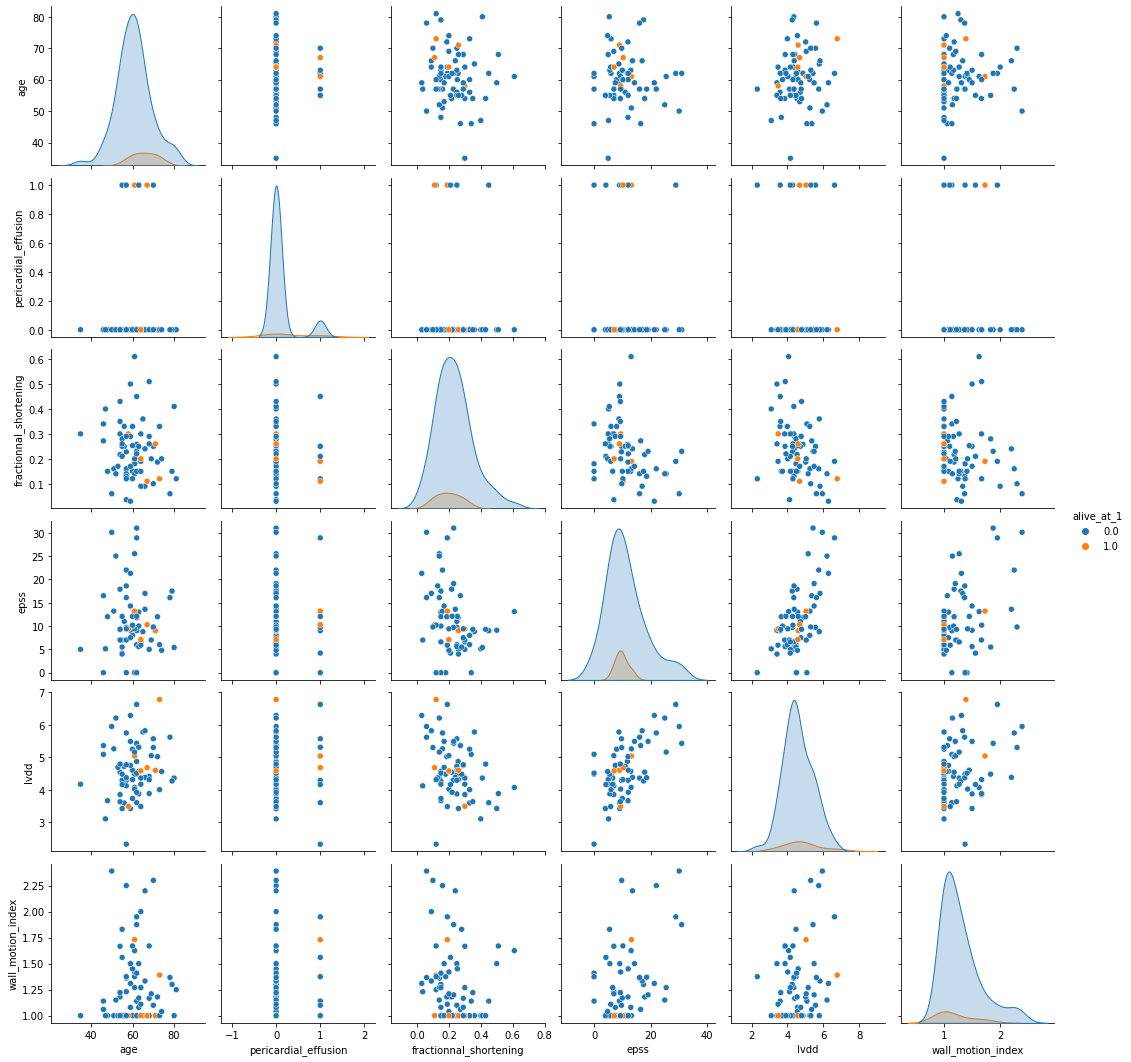

In [16]:
df=pd.concat((X_train, y_train), axis=1)
sns.pairplot(df, hue='alive_at_1')
plt.show()

In [17]:
X_train.shape, y_train.shape, y_train.sum()

((77, 6), (77,), 6.0)

## Les modèles.

### Les fonctions que nous allons utiliser.

In [18]:
# Les scores que nous allons utiliser (pour obtenir une moyenne de la matrice de confusion obtenue
#lors de la cross_validation)

def scorer(clf, X, y_true) :
  y_pred=clf.predict(X)
  f1=f1_score(y_true, y_pred, zero_division=0)
  recall=recall_score(y_true, y_pred, zero_division=0)
  accuracy=accuracy_score(y_true, y_pred)
  precision=precision_score(y_true, y_pred, zero_division=0)
  conf_matrix = confusion_matrix(y_true, y_pred, labels=[0,1])
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
  spe=tn/(tn+fp)
  return {'f1':f1, 'recall':recall, 'accuracy':accuracy, 
          'precision': precision, 'specificity':spe, 'tn':tn, 'fp':fp, 'fn':fn, 'tp':tp}

def scorer2(y_true, y_pred) :
  f1=f1_score(y_true, y_pred,zero_division=0)
  recall=recall_score(y_true, y_pred,zero_division=0)
  accuracy=accuracy_score(y_true, y_pred)
  precision=precision_score(y_true, y_pred, zero_division=0)
  conf_matrix = confusion_matrix(y_true, y_pred, labels=[0,1])
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
  spe=tn/(tn+fp)
  return {'f1':f1, 'recall':recall, 'accuracy':accuracy, 
          'precision': precision, 'specificity':spe, 'tn':tn, 'fp':fp, 'fn':fn, 'tp':tp}


In [19]:
#return best param of grid search to maximize refit score 

def grid_search(pipe, distribution, X, y, refit):
  grid_search=RandomizedSearchCV(pipe, distribution, n_iter=50, cv=5, scoring=scorer, 
            refit= refit, return_train_score=True, random_state=123456, error_score='raise')
  grid_search.fit(X, y)

  print('Test : ' + refit + ' score is {} +/- {}'. format(grid_search.cv_results_['mean_test_' + refit].max(), 
                                      grid_search.cv_results_['std_test_' + refit][grid_search.cv_results_['mean_test_' + refit].argmax()]))

  print('Train : ' + refit + ' score is {} +/- {}'. format(grid_search.cv_results_['mean_train_' + refit][grid_search.cv_results_['mean_test_' + refit].argmax()], 
                                      grid_search.cv_results_['std_train_' + refit][grid_search.cv_results_['mean_test_' + refit].argmax()]))
  
  for score in ['f1', 'recall', 'accuracy', 'precision', 'specificity']:
    if score != refit :
      print('Test : ' + score + ' score is {} +/- {}'. format(grid_search.cv_results_['mean_test_' + score][grid_search.cv_results_['mean_test_' + refit].argmax()], 
                                      grid_search.cv_results_['std_test_' + score][grid_search.cv_results_['mean_test_' + refit].argmax()]))

      print('Train : ' + score + ' score is {} +/- {}'. format(grid_search.cv_results_['mean_train_' + score][grid_search.cv_results_['mean_test_' + refit].argmax()], 
                                      grid_search.cv_results_['std_train_' + score][grid_search.cv_results_['mean_test_' + refit].argmax()]))

  print('Mean of confusion matrix : ')
  matrix=np.array([[grid_search.cv_results_['mean_test_tn'][grid_search.cv_results_['mean_test_' +refit].argmax()],grid_search.cv_results_['mean_test_fp'][grid_search.cv_results_['mean_test_' +refit].argmax() ]],
                 [grid_search.cv_results_['mean_test_fn'][grid_search.cv_results_['mean_test_' +refit].argmax()] , grid_search.cv_results_['mean_test_tp'][grid_search.cv_results_['mean_test_' +refit].argmax()] ]])
  print(matrix)

  return ('Best parameters :' , grid_search.best_params_)

# same algo but return estimator with best params
def grid_search_estimator(pipe, distribution, X, y, refit):
  grid_search=RandomizedSearchCV(pipe, distribution, n_iter=50, cv=5, scoring=scorer, 
                         refit= refit, return_train_score=True, random_state=123456, error_score='raise' )
  grid_search.fit(X, y)

  return (grid_search.best_estimator_)

#implementation of our threshold function as in article found on the web site

def cost_sensitive(pipe, c_min, c_max, step, X, y) : 
  stratified_shuffle_split=StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=123456)
  for c in np.linspace(c_min,c_max, step) :
    test_score={'f1':[], 'recall':[], 'accuracy':[], 
          'precision': [], 'specificity':[], 'tn':[], 'fp':[], 'fn':[], 'tp':[]}
    train_score={'f1':[], 'recall':[], 'accuracy':[], 
          'precision': [], 'specificity':[], 'tn':[], 'fp':[], 'fn':[], 'tp':[]}
    matrix=np.zeros((2,2))
    for train_index, test_index in stratified_shuffle_split.split(X, y) : 
      data_train = X.iloc[train_index]
      target_train= y.iloc[train_index]
      data_test=X.iloc[test_index]
      target_test=y.iloc[test_index]

      pipe.fit(data_train, target_train)
    
      target_test_pred_proba = pipe.predict_proba(data_test)
      # threshold moving and normalisation
      target_test_pred_proba = target_test_pred_proba* np.array((1,c))/np.repeat(np.sum(target_test_pred_proba*np.array((1,c)), axis=1).reshape((len(target_test_pred_proba),1)), 2, axis=1)
      target_test_pred= np.argmax(target_test_pred_proba, axis=1)

      score=scorer2(target_test, target_test_pred)

      for itm in score.keys():
        test_score[itm].append(score[itm])
      
      matrix=matrix+np.array([[score['tn'],score['fp']], [score['fn'],score['tp']] ])
      
      target_train_pred_proba= pipe.predict_proba(data_train)
      target_train_pred_proba = target_train_pred_proba* np.array((1,c))/np.repeat(np.sum(target_train_pred_proba*np.array((1,c)), axis=1).reshape((len(target_train_pred_proba),1)), 2, axis=1)
      target_train_pred= np.argmax(target_train_pred_proba, axis=1)

      score=scorer2(target_train, target_train_pred)

      for itm in score.keys():
        train_score[itm].append(score[itm])

    print('With cost parameter {}'.format(c))

    for scr in ['f1', 'recall', 'accuracy', 'precision', 'specificity'] :
      print( 'On test data, ' + scr + ' score is {} +/- {}'. format(statistics.mean(test_score[scr]), 
                                                           statistics.pstdev(test_score[scr])))
      print( 'On train data, ' + scr + ' score is {} +/- {}'. format(statistics.mean(train_score[scr]), 
                                                           statistics.pstdev(train_score[scr])))

    print('Sum of Confusion matrix during 5-fold cross validation is : \n {} \n'.format (matrix))


# for keras neural networks
def cost_sensitive_nn(model, c_min, c_max, step , X, y) :
  stratified_shuffle_split=StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=123456)
  for c in np.linspace(c_min,c_max, step) :
    clf = KerasClassifier(model=model, epochs=200, verbose=0)
    pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), StandardScaler(), clf)
    test_score={'f1':[], 'recall':[], 'accuracy':[], 
          'precision': [], 'specificity':[], 'tn':[], 'fp':[], 'fn':[], 'tp':[]}
    train_score={'f1':[], 'recall':[], 'accuracy':[], 
          'precision': [], 'specificity':[], 'tn':[], 'fp':[], 'fn':[], 'tp':[]}
    matrix=np.zeros((2,2))
    for train_index, test_index in stratified_shuffle_split.split(X, y) : 
      data_train = X.iloc[train_index]
      target_train= y.iloc[train_index]
      data_test=X.iloc[test_index]
      target_test=y.iloc[test_index]

      pipe.fit(data_train, target_train)
    
      target_test_pred_proba = pipe.predict_proba(data_test)
      # threshold moving and normalisation
      target_test_pred_proba = target_test_pred_proba* np.array((1,c))/np.repeat(np.sum(target_test_pred_proba*np.array((1,c)), axis=1).reshape((len(target_test_pred_proba),1)), 2, axis=1)
      target_test_pred= np.argmax(target_test_pred_proba, axis=1)

      score=scorer2(target_test, target_test_pred)

      for itm in score.keys():
        test_score[itm].append(score[itm])
      
      matrix=matrix+np.array([[score['tn'],score['fp']], [score['fn'],score['tp']] ])
      
      target_train_pred_proba= pipe.predict_proba(data_train)
      target_train_pred_proba = target_train_pred_proba* np.array((1,c))/np.repeat(np.sum(target_train_pred_proba*np.array((1,c)), axis=1).reshape((len(target_train_pred_proba),1)), 2, axis=1)
      target_train_pred= np.argmax(target_train_pred_proba, axis=1)

      score=scorer2(target_train, target_train_pred)

      for itm in score.keys():
        train_score[itm].append(score[itm])

    print('With cost parameter {}'.format(c))

    for scr in ['f1', 'recall', 'accuracy', 'precision', 'specificity'] :
      print( 'On test data, ' + scr + ' score is {} +/- {}'. format(statistics.mean(test_score[scr]), 
                                                           statistics.pstdev(test_score[scr])))
      print( 'On train data, ' + scr + ' score is {} +/- {}'. format(statistics.mean(train_score[scr]), 
                                                           statistics.pstdev(train_score[scr])))

    print('Sum of Confusion matrix during 5-fold cross validation is : \n {} \n'.format (matrix))

# for keras neural networks for oversampling
def cost_sensitive_nn2(pipe , c,X, y) :
  stratified_shuffle_split=StratifiedShuffleSplit(n_splits=5, test_size=0.2)
  test_score={'f1':[], 'recall':[], 'accuracy':[], 
          'precision': [], 'specificity':[], 'tn':[], 'fp':[], 'fn':[], 'tp':[]}
  train_score={'f1':[], 'recall':[], 'accuracy':[], 
          'precision': [], 'specificity':[], 'tn':[], 'fp':[], 'fn':[], 'tp':[]}
  matrix=np.zeros((2,2))
  for train_index, test_index in stratified_shuffle_split.split(X, y) : 
    data_train = X.iloc[train_index]
    target_train= y.iloc[train_index]
    data_test=X.iloc[test_index]
    target_test=y.iloc[test_index]
    pipe.fit(data_train, target_train)
    
    target_test_pred_proba = pipe.predict_proba(data_test)
    # threshold moving and normalisation
    target_test_pred_proba = target_test_pred_proba* np.array((1,c))/np.repeat(np.sum(target_test_pred_proba*np.array((1,c)), axis=1).reshape((len(target_test_pred_proba),1)), 2, axis=1)
    target_test_pred= np.argmax(target_test_pred_proba, axis=1)

    score=scorer2(target_test, target_test_pred)

    for itm in score.keys():
      test_score[itm].append(score[itm])
      
    matrix=matrix+np.array([[score['tn'],score['fp']], [score['fn'],score['tp']] ])
      
    target_train_pred_proba= pipe.predict_proba(data_train)
    target_train_pred_proba = target_train_pred_proba* np.array((1,c))/np.repeat(np.sum(target_train_pred_proba*np.array((1,c)), axis=1).reshape((len(target_train_pred_proba),1)), 2, axis=1)
    target_train_pred= np.argmax(target_train_pred_proba, axis=1)

    score=scorer2(target_train, target_train_pred)

    for itm in score.keys():
      train_score[itm].append(score[itm])

  print('With cost parameter {}'.format(c))

  for scr in ['f1', 'recall', 'accuracy', 'precision', 'specificity'] :
    print( 'On test data, ' + scr + ' score is {} +/- {}'. format(statistics.mean(test_score[scr]), 
                                                           statistics.pstdev(test_score[scr])))
    print( 'On train data, ' + scr + ' score is {} +/- {}'. format(statistics.mean(train_score[scr]), 
                                                           statistics.pstdev(train_score[scr])))

  print('Sum of Confusion matrix during 5-fold cross validation is : \n {} \n'.format (matrix))


### Logistic regression.

#### Refit = F1 score

In [ ]:
clf=LogisticRegression(solver='saga', max_iter=10**8)
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), clf)
refit= 'f1'

#without class weight 
distribution = dict(logisticregression__C=uniform(loc=0, scale=4),
                    logisticregression__penalty=['l2', 'l1' ], 
                    simpleimputer__strategy= ['mean', 'median'])
print('Results without class weight hyperparameter.')
display(grid_search(pipe, distribution, X_train, y_train, refit))

# sklearn implemented class weight hyperparameter
weight=[ 'balanced', None, {1:0.8,0:0.1},{1:0.7,0:0.1},{1:0.9,0:0.1},
        {1:0.6,0:0.1},{1:0.5,0:0.1},{1:0.4,0:0.1}, {1:0.2, 0:0.1}  ]


distribution = dict(logisticregression__C=uniform(loc=0, scale=4),
                    logisticregression__penalty=['l2', 'l1' ], 
                    simpleimputer__strategy= ['mean', 'median'], 
                    logisticregression__class_weight=weight)
print('\n Results with sklearn implemented class weight.')
display(grid_search(pipe, distribution, X_train, y_train, refit))

# our implemented class weight function
distribution = dict(logisticregression__C=uniform(loc=0, scale=4),
                    logisticregression__penalty=['l2', 'l1' ], 
                    simpleimputer__strategy= ['mean', 'median'])

print('\n Results with our implemented class weight.')
best_pipe = grid_search_estimator(pipe, distribution, X_train, y_train, refit)
cost_sensitive(best_pipe, 1, 10,10, X_train, y_train)

Results without class weight hyperparameter.
Test : f1 score is 0.0 +/- 0.0
Train : f1 score is 0.0 +/- 0.0
Test : recall score is 0.0 +/- 0.0
Train : recall score is 0.0 +/- 0.0
Test : accuracy score is 0.9225000000000001 +/- 0.02380476142847617
Train : accuracy score is 0.9221047065044949 +/- 0.006182002542595765
Test : precision score is 0.0 +/- 0.0
Train : precision score is 0.0 +/- 0.0
Test : specificity score is 1.0 +/- 0.0
Train : specificity score is 1.0 +/- 0.0
Mean of confusion matrix : 
[[14.2  0. ]
 [ 1.2  0. ]]


('Best parameters :',
 {'logisticregression__C': 0.5078793321524038,
  'logisticregression__penalty': 'l2',
  'simpleimputer__strategy': 'median'})


 Results with sklearn implemented class weight.
Test : f1 score is 0.17777777777777778 +/- 0.1507184440694504
Train : f1 score is 0.27002835873803616 +/- 0.06914668925808634
Test : recall score is 0.5 +/- 0.4472135954999579
Train : recall score is 0.79 +/- 0.12806248474865697
Test : accuracy score is 0.6866666666666666 +/- 0.08259674462242578
Train : accuracy score is 0.6591750396615548 +/- 0.05544351834045625
Test : precision score is 0.11499999999999999 +/- 0.1019803902718557
Train : precision score is 0.16342083842083843 +/- 0.045442607007702564
Test : specificity score is 0.702857142857143 +/- 0.10743768958264667
Train : specificity score is 0.6480576441102757 +/- 0.05099942722227521
Mean of confusion matrix : 
[[10.   4.2]
 [ 0.6  0.6]]


('Best parameters :',
 {'logisticregression__C': 0.22357190398323556,
  'logisticregression__class_weight': 'balanced',
  'logisticregression__penalty': 'l2',
  'simpleimputer__strategy': 'mean'})


 Results with our implemented class weight.
With cost parameter 1.0
On test data, f1 score is 0.0 +/- 0.0
On train data, f1 score is 0.0 +/- 0.0
On test data, recall score is 0.0 +/- 0.0
On train data, recall score is 0.0 +/- 0.0
On test data, accuracy score is 0.9375 +/- 0.0
On train data, accuracy score is 0.9180327868852459 +/- 0.0
On test data, precision score is 0.0 +/- 0.0
On train data, precision score is 0.0 +/- 0.0
On test data, specificity score is 1.0 +/- 0.0
On train data, specificity score is 1.0 +/- 0.0
Sum of Confusion matrix during 5-fold cross validation is : 
 [[75.  0.]
 [ 5.  0.]] 

With cost parameter 2.0
On test data, f1 score is 0.0 +/- 0.0
On train data, f1 score is 0.0 +/- 0.0
On test data, recall score is 0.0 +/- 0.0
On train data, recall score is 0.0 +/- 0.0
On test data, accuracy score is 0.9375 +/- 0.0
On train data, accuracy score is 0.9180327868852459 +/- 0.0
On test data, precision score is 0.0 +/- 0.0
On train data, precision score is 0.0 +/- 0.0
On te

#### Refit specificity

In [ ]:
clf=LogisticRegression(solver='saga', max_iter=10**8)
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), clf)
refit= 'specificity'

#without class weight 
distribution = dict(logisticregression__C=uniform(loc=0, scale=4),
                    logisticregression__penalty=['l2', 'l1' ], 
                    simpleimputer__strategy= ['mean', 'median'])
print('Results without class weight hyperparameter.')
display(grid_search(pipe, distribution, X_train, y_train, refit))

# sklearn implemented class weight hyperparameter
weight=[ 'balanced', None, {1:0.8,0:0.1},{1:0.7,0:0.1},{1:0.9,0:0.1},
        {1:0.6,0:0.1},{1:0.5,0:0.1},{1:0.4,0:0.1}, {1:0.2, 0:0.1},{1:0.15, 0:0.1}  ]


distribution = dict(logisticregression__C=uniform(loc=0, scale=4),
                    logisticregression__penalty=['l2', 'l1' ], 
                    simpleimputer__strategy= ['mean', 'median'], 
                    logisticregression__class_weight=weight)
print('\n Results with sklearn implemented class weight.')
display(grid_search(pipe, distribution, X_train, y_train, refit))

# our implemented class weight function
distribution = dict(logisticregression__C=uniform(loc=0, scale=4),
                    logisticregression__penalty=['l2', 'l1' ], 
                    simpleimputer__strategy= ['mean', 'median'])

print('\n Results with our implemented class weight.')
best_pipe = grid_search_estimator(pipe, distribution, X_train, y_train, refit)
cost_sensitive(best_pipe, 1, 10,10, X_train, y_train)

Results without class weight hyperparameter.
Test : specificity score is 1.0 +/- 0.0
Train : specificity score is 1.0 +/- 0.0
Test : f1 score is 0.0 +/- 0.0
Train : f1 score is 0.0 +/- 0.0
Test : recall score is 0.0 +/- 0.0
Train : recall score is 0.0 +/- 0.0
Test : accuracy score is 0.9225000000000001 +/- 0.02380476142847617
Train : accuracy score is 0.9221047065044949 +/- 0.006182002542595765
Test : precision score is 0.0 +/- 0.0
Train : precision score is 0.0 +/- 0.0
Mean of confusion matrix : 
[[14.2  0. ]
 [ 1.2  0. ]]


('Best parameters :',
 {'logisticregression__C': 0.5078793321524038,
  'logisticregression__penalty': 'l2',
  'simpleimputer__strategy': 'median'})


 Results with sklearn implemented class weight.
Test : specificity score is 1.0 +/- 0.0
Train : specificity score is 1.0 +/- 0.0
Test : f1 score is 0.0 +/- 0.0
Train : f1 score is 0.0 +/- 0.0
Test : recall score is 0.0 +/- 0.0
Train : recall score is 0.0 +/- 0.0
Test : accuracy score is 0.9225000000000001 +/- 0.02380476142847617
Train : accuracy score is 0.9221047065044949 +/- 0.006182002542595765
Test : precision score is 0.0 +/- 0.0
Train : precision score is 0.0 +/- 0.0
Mean of confusion matrix : 
[[14.2  0. ]
 [ 1.2  0. ]]


('Best parameters :',
 {'logisticregression__C': 2.5666646811001415,
  'logisticregression__class_weight': None,
  'logisticregression__penalty': 'l2',
  'simpleimputer__strategy': 'mean'})


 Results with our implemented class weight.
With cost parameter 1.0
On test data, f1 score is 0.0 +/- 0.0
On train data, f1 score is 0.0 +/- 0.0
On test data, recall score is 0.0 +/- 0.0
On train data, recall score is 0.0 +/- 0.0
On test data, accuracy score is 0.9375 +/- 0.0
On train data, accuracy score is 0.9180327868852459 +/- 0.0
On test data, precision score is 0.0 +/- 0.0
On train data, precision score is 0.0 +/- 0.0
On test data, specificity score is 1.0 +/- 0.0
On train data, specificity score is 1.0 +/- 0.0
Sum of Confusion matrix during 5-fold cross validation is : 
 [[75.  0.]
 [ 5.  0.]] 

With cost parameter 2.0
On test data, f1 score is 0.0 +/- 0.0
On train data, f1 score is 0.0 +/- 0.0
On test data, recall score is 0.0 +/- 0.0
On train data, recall score is 0.0 +/- 0.0
On test data, accuracy score is 0.9375 +/- 0.0
On train data, accuracy score is 0.9180327868852459 +/- 0.0
On test data, precision score is 0.0 +/- 0.0
On train data, precision score is 0.0 +/- 0.0
On te

#### Refit recall

In [ ]:
clf=LogisticRegression(solver='saga', max_iter=10**8)
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), clf)
refit= 'recall'

#without class weight 
distribution = dict(logisticregression__C=uniform(loc=0, scale=4),
                    logisticregression__penalty=['l2', 'l1' ], 
                    simpleimputer__strategy= ['mean', 'median'])
print('Results without class weight hyperparameter.')
display(grid_search(pipe, distribution, X_train, y_train, refit))

# sklearn implemented class weight hyperparameter
weight=[ 'balanced', None, {1:0.8,0:0.1},{1:0.7,0:0.1},{1:0.9,0:0.1},
        {1:0.6,0:0.1},{1:0.5,0:0.1},{1:0.4,0:0.1}, {1:0.2, 0:0.1}  ]


distribution = dict(logisticregression__C=uniform(loc=0, scale=4),
                    logisticregression__penalty=['l2', 'l1' ], 
                    simpleimputer__strategy= ['mean', 'median'], 
                    logisticregression__class_weight=weight)
print('\n Results with sklearn implemented class weight.')
display(grid_search(pipe, distribution, X_train, y_train, refit))

# our implemented class weight function
distribution = dict(logisticregression__C=uniform(loc=0, scale=4),
                    logisticregression__penalty=['l2', 'l1' ], 
                    simpleimputer__strategy= ['mean', 'median'])

print('\n Results with our implemented class weight.')
best_pipe = grid_search_estimator(pipe, distribution, X_train, y_train, refit)
cost_sensitive(best_pipe, 1, 10,10, X_train, y_train)

Results without class weight hyperparameter.
Test : recall score is 0.0 +/- 0.0
Train : recall score is 0.0 +/- 0.0
Test : f1 score is 0.0 +/- 0.0
Train : f1 score is 0.0 +/- 0.0
Test : accuracy score is 0.9225000000000001 +/- 0.02380476142847617
Train : accuracy score is 0.9221047065044949 +/- 0.006182002542595765
Test : precision score is 0.0 +/- 0.0
Train : precision score is 0.0 +/- 0.0
Test : specificity score is 1.0 +/- 0.0
Train : specificity score is 1.0 +/- 0.0
Mean of confusion matrix : 
[[14.2  0. ]
 [ 1.2  0. ]]


('Best parameters :',
 {'logisticregression__C': 0.5078793321524038,
  'logisticregression__penalty': 'l2',
  'simpleimputer__strategy': 'median'})


 Results with sklearn implemented class weight.
Test : recall score is 0.5 +/- 0.4472135954999579
Train : recall score is 0.7500000000000001 +/- 0.07745966692414837
Test : f1 score is 0.16999999999999998 +/- 0.15362291495737218
Train : f1 score is 0.31398080180688875 +/- 0.035517574692426244
Test : accuracy score is 0.6616666666666667 +/- 0.1151810169544733
Train : accuracy score is 0.7436805922792173 +/- 0.034751046966494364
Test : precision score is 0.10555555555555556 +/- 0.09686442096757052
Train : precision score is 0.1990799943165672 +/- 0.025002729320019044
Test : specificity score is 0.6742857142857143 +/- 0.13504345483538827
Train : specificity score is 0.743045112781955 +/- 0.038835190989883576
Mean of confusion matrix : 
[[9.6 4.6]
 [0.6 0.6]]


('Best parameters :',
 {'logisticregression__C': 2.823280510224,
  'logisticregression__class_weight': 'balanced',
  'logisticregression__penalty': 'l1',
  'simpleimputer__strategy': 'mean'})


 Results with our implemented class weight.
With cost parameter 1.0
On test data, f1 score is 0.0 +/- 0.0
On train data, f1 score is 0.0 +/- 0.0
On test data, recall score is 0.0 +/- 0.0
On train data, recall score is 0.0 +/- 0.0
On test data, accuracy score is 0.9375 +/- 0.0
On train data, accuracy score is 0.9180327868852459 +/- 0.0
On test data, precision score is 0.0 +/- 0.0
On train data, precision score is 0.0 +/- 0.0
On test data, specificity score is 1.0 +/- 0.0
On train data, specificity score is 1.0 +/- 0.0
Sum of Confusion matrix during 5-fold cross validation is : 
 [[75.  0.]
 [ 5.  0.]] 

With cost parameter 2.0
On test data, f1 score is 0.0 +/- 0.0
On train data, f1 score is 0.0 +/- 0.0
On test data, recall score is 0.0 +/- 0.0
On train data, recall score is 0.0 +/- 0.0
On test data, accuracy score is 0.9375 +/- 0.0
On train data, accuracy score is 0.9180327868852459 +/- 0.0
On test data, precision score is 0.0 +/- 0.0
On train data, precision score is 0.0 +/- 0.0
On te

#### Refit accuracy

In [ ]:
clf=LogisticRegression(solver='saga', max_iter=10**8)
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), clf)
refit= 'accuracy'

#without class weight 
distribution = dict(logisticregression__C=uniform(loc=0, scale=4),
                    logisticregression__penalty=['l2', 'l1' ], 
                    simpleimputer__strategy= ['mean', 'median'])
print('Results without class weight hyperparameter.')
display(grid_search(pipe, distribution, X_train, y_train, refit))

# sklearn implemented class weight hyperparameter
weight=[ 'balanced', None, {1:0.8,0:0.1},{1:0.7,0:0.1},{1:0.9,0:0.1},
        {1:0.6,0:0.1},{1:0.5,0:0.1},{1:0.4,0:0.1}, {1:0.2, 0:0.1},{1:0.15, 0:0.1}  ]


distribution = dict(logisticregression__C=uniform(loc=0, scale=4),
                    logisticregression__penalty=['l2', 'l1' ], 
                    simpleimputer__strategy= ['mean', 'median'], 
                    logisticregression__class_weight=weight)
print('\n Results with sklearn implemented class weight.')
display(grid_search(pipe, distribution, X_train, y_train, refit))

# our implemented class weight function
distribution = dict(logisticregression__C=uniform(loc=0, scale=4),
                    logisticregression__penalty=['l2', 'l1' ], 
                    simpleimputer__strategy= ['mean', 'median'])

print('\n Results with our implemented class weight.')
best_pipe = grid_search_estimator(pipe, distribution, X_train, y_train, refit)
cost_sensitive(best_pipe, 1, 10,10, X_train, y_train)

Results without class weight hyperparameter.
Test : accuracy score is 0.9225000000000001 +/- 0.02380476142847617
Train : accuracy score is 0.9221047065044949 +/- 0.006182002542595765
Test : f1 score is 0.0 +/- 0.0
Train : f1 score is 0.0 +/- 0.0
Test : recall score is 0.0 +/- 0.0
Train : recall score is 0.0 +/- 0.0
Test : precision score is 0.0 +/- 0.0
Train : precision score is 0.0 +/- 0.0
Test : specificity score is 1.0 +/- 0.0
Train : specificity score is 1.0 +/- 0.0
Mean of confusion matrix : 
[[14.2  0. ]
 [ 1.2  0. ]]


('Best parameters :',
 {'logisticregression__C': 0.5078793321524038,
  'logisticregression__penalty': 'l2',
  'simpleimputer__strategy': 'median'})


 Results with sklearn implemented class weight.
Test : accuracy score is 0.9225000000000001 +/- 0.02380476142847617
Train : accuracy score is 0.9221047065044949 +/- 0.006182002542595765
Test : f1 score is 0.0 +/- 0.0
Train : f1 score is 0.0 +/- 0.0
Test : recall score is 0.0 +/- 0.0
Train : recall score is 0.0 +/- 0.0
Test : precision score is 0.0 +/- 0.0
Train : precision score is 0.0 +/- 0.0
Test : specificity score is 1.0 +/- 0.0
Train : specificity score is 1.0 +/- 0.0
Mean of confusion matrix : 
[[14.2  0. ]
 [ 1.2  0. ]]


('Best parameters :',
 {'logisticregression__C': 2.5666646811001415,
  'logisticregression__class_weight': None,
  'logisticregression__penalty': 'l2',
  'simpleimputer__strategy': 'mean'})


 Results with our implemented class weight.
With cost parameter 1.0
On test data, f1 score is 0.0 +/- 0.0
On train data, f1 score is 0.0 +/- 0.0
On test data, recall score is 0.0 +/- 0.0
On train data, recall score is 0.0 +/- 0.0
On test data, accuracy score is 0.9375 +/- 0.0
On train data, accuracy score is 0.9180327868852459 +/- 0.0
On test data, precision score is 0.0 +/- 0.0
On train data, precision score is 0.0 +/- 0.0
On test data, specificity score is 1.0 +/- 0.0
On train data, specificity score is 1.0 +/- 0.0
Sum of Confusion matrix during 5-fold cross validation is : 
 [[75.  0.]
 [ 5.  0.]] 

With cost parameter 2.0
On test data, f1 score is 0.0 +/- 0.0
On train data, f1 score is 0.0 +/- 0.0
On test data, recall score is 0.0 +/- 0.0
On train data, recall score is 0.0 +/- 0.0
On test data, accuracy score is 0.9375 +/- 0.0
On train data, accuracy score is 0.9180327868852459 +/- 0.0
On test data, precision score is 0.0 +/- 0.0
On train data, precision score is 0.0 +/- 0.0
On te

#### Conclusion :    
Les meilleurs scores obtenus sont en utilisant refit avec rappel ou score F1 et en utilisant class_weight='balanced'. \\

Class_weight ='balanced' est équivalent à écire {1:6.41 , 0: 0.54} (soit un rapport de environ 12 entre les deux classes). 'balanced' permet d'avoir un bon compromis et ne pas trop classer de patient positif et donc évite d'avoir un nombre de faux positifs excessif. 

On remarque aussi que la méthode de threshold moving ne donne pas de bons résultats ici (même si l'on prend un coût supérieur à 10).


### Decision tree

#### Avec refit recall

In [ ]:
clf=DecisionTreeClassifier(class_weight='balanced')
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), StandardScaler(), clf)
refit='recall'

#without class weight parameter
distribution=dict(simpleimputer__strategy= ['mean', 'median'], 
                  decisiontreeclassifier__min_samples_split=randint(2,10), 
                  decisiontreeclassifier__max_depth=randint(3,10), 
                  decisiontreeclassifier__min_samples_leaf=randint(1,10), 
                  decisiontreeclassifier__criterion=['gini', 'entropy'], 
                  decisiontreeclassifier__splitter=['best', 'random'],
                  decisiontreeclassifier__ccp_alpha=[0, 0.001, 0.0001])
print('Results without class weight hyperparameter.')
params=grid_search(pipe, distribution, X_train, y_train, refit)
display(params)

# sklearn implemented class weight hyperparameter
weight=[ 'balanced', None, {1:0.8,0:0.1},{1:0.7,0:0.1},{1:0.9,0:0.1},
        {1:0.6,0:0.1},{1:0.5,0:0.1},{1:0.4,0:0.1}, {1:0.2, 0:0.1},{1:0.15, 0:0.01}  ]

distribution=dict(simpleimputer__strategy= ['mean', 'median'], 
                  decisiontreeclassifier__min_samples_split=randint(2,10), 
                  decisiontreeclassifier__max_depth=randint(3,10), 
                  decisiontreeclassifier__min_samples_leaf=randint(1,10), 
                  decisiontreeclassifier__criterion=['gini', 'entropy'], 
                  decisiontreeclassifier__splitter=['best', 'random'],
                  decisiontreeclassifier__ccp_alpha=[0, 0.001, 0.0001],
                  decisiontreeclassifier__class_weight=weight)

print('\n Results with scikit class weight hyperparameter.')
params=grid_search(pipe, distribution, X_train, y_train, refit)
display(params)

Results without class weight hyperparameter.
Test : recall score is 0.7 +/- 0.4
Train : recall score is 0.9199999999999999 +/- 0.09797958971132709
Test : f1 score is 0.15414141414141413 +/- 0.07927227421899181
Train : f1 score is 0.26633911225059015 +/- 0.041956725291677634
Test : accuracy score is 0.48250000000000004 +/- 0.077746025264604
Train : accuracy score is 0.5933897408778424 +/- 0.09706538707643587
Test : precision score is 0.08722222222222223 +/- 0.04456926915584796
Train : precision score is 0.15719968818366986 +/- 0.029289165094332797
Test : specificity score is 0.46571428571428564 +/- 0.10004080800006628
Train : specificity score is 0.5663533834586466 +/- 0.11022733332596976
Mean of confusion matrix : 
[[6.6 7.6]
 [0.4 0.8]]


('Best parameters :',
 {'decisiontreeclassifier__ccp_alpha': 0.001,
  'decisiontreeclassifier__criterion': 'gini',
  'decisiontreeclassifier__max_depth': 9,
  'decisiontreeclassifier__min_samples_leaf': 8,
  'decisiontreeclassifier__min_samples_split': 9,
  'decisiontreeclassifier__splitter': 'random',
  'simpleimputer__strategy': 'median'})


 Results with scikit class weight hyperparameter.
Test : recall score is 0.4 +/- 0.48989794855663565
Train : recall score is 0.82 +/- 0.22271057451320087
Test : f1 score is 0.12444444444444444 +/- 0.1624503722888628
Train : f1 score is 0.3113235294117647 +/- 0.04909122219792265
Test : accuracy score is 0.6116666666666667 +/- 0.12476088240220883
Train : accuracy score is 0.717451084082496 +/- 0.07714760442640851
Test : precision score is 0.075 +/- 0.1
Train : precision score is 0.19485312899106 +/- 0.029863480219607334
Test : specificity score is 0.6361904761904762 +/- 0.13568002909339524
Train : specificity score is 0.7072681704260652 +/- 0.09852397780450885
Mean of confusion matrix : 
[[9.  5.2]
 [0.8 0.4]]


('Best parameters :',
 {'decisiontreeclassifier__ccp_alpha': 0,
  'decisiontreeclassifier__class_weight': {0: 0.1, 1: 0.9},
  'decisiontreeclassifier__criterion': 'gini',
  'decisiontreeclassifier__max_depth': 6,
  'decisiontreeclassifier__min_samples_leaf': 5,
  'decisiontreeclassifier__min_samples_split': 7,
  'decisiontreeclassifier__splitter': 'random',
  'simpleimputer__strategy': 'mean'})

#### Avec refit f1

In [ ]:
clf=DecisionTreeClassifier(class_weight='balanced')
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), StandardScaler(), clf)
refit='f1'

#without class weight parameter
distribution=dict(simpleimputer__strategy= ['mean', 'median'], 
                  decisiontreeclassifier__min_samples_split=randint(2,10), 
                  decisiontreeclassifier__max_depth=randint(3,10), 
                  decisiontreeclassifier__min_samples_leaf=randint(1,10), 
                  decisiontreeclassifier__criterion=['gini', 'entropy'], 
                  decisiontreeclassifier__splitter=['best', 'random'],
                  decisiontreeclassifier__ccp_alpha=[0, 0.001, 0.0001])
print('Results without class weight hyperparameter.')
params=grid_search(pipe, distribution, X_train, y_train, refit)
display(params)

# sklearn implemented class weight hyperparameter
weight=[ 'balanced', None, {1:0.8,0:0.1},{1:0.7,0:0.1},{1:0.9,0:0.1},
        {1:0.6,0:0.1},{1:0.5,0:0.1},{1:0.4,0:0.1}, {1:0.2, 0:0.1},{1:0.15, 0:0.01}  ]

distribution=dict(simpleimputer__strategy= ['mean', 'median'], 
                  decisiontreeclassifier__min_samples_split=randint(2,10), 
                  decisiontreeclassifier__max_depth=randint(3,10), 
                  decisiontreeclassifier__min_samples_leaf=randint(1,10), 
                  decisiontreeclassifier__criterion=['gini', 'entropy'], 
                  decisiontreeclassifier__splitter=['best', 'random'],
                  decisiontreeclassifier__ccp_alpha=[0, 0.001, 0.0001],
                  decisiontreeclassifier__class_weight=weight)

print('\n Results with scikit class weight hyperparameter.')
params=grid_search(pipe, distribution, X_train, y_train, refit)
display(params)

Results without class weight hyperparameter.
Test : f1 score is 0.18333333333333332 +/- 0.15275252316519466
Train : f1 score is 0.31292584892584896 +/- 0.03811826383685131
Test : recall score is 0.5 +/- 0.4472135954999579
Train : recall score is 0.8800000000000001 +/- 0.0979795897113271
Test : accuracy score is 0.6991666666666667 +/- 0.08516324194027479
Train : accuracy score is 0.6918032786885245 +/- 0.07362783763509972
Test : precision score is 0.11857142857142858 +/- 0.10257898897723566
Train : precision score is 0.19267857142857142 +/- 0.03270431157301515
Test : specificity score is 0.7161904761904762 +/- 0.10374397231349503
Train : specificity score is 0.6764411027568922 +/- 0.08683550481775394
Mean of confusion matrix : 
[[10.2  4. ]
 [ 0.6  0.6]]


('Best parameters :',
 {'decisiontreeclassifier__ccp_alpha': 0,
  'decisiontreeclassifier__criterion': 'entropy',
  'decisiontreeclassifier__max_depth': 9,
  'decisiontreeclassifier__min_samples_leaf': 7,
  'decisiontreeclassifier__min_samples_split': 8,
  'decisiontreeclassifier__splitter': 'random',
  'simpleimputer__strategy': 'mean'})


 Results with scikit class weight hyperparameter.
Test : f1 score is 0.2 +/- 0.24494897427831783
Train : f1 score is 0.866089466089466 +/- 0.07630408251502793
Test : recall score is 0.3 +/- 0.39999999999999997
Train : recall score is 1.0 +/- 0.0
Test : accuracy score is 0.8316666666666667 +/- 0.048989794855663564
Train : accuracy score is 0.9740877842411422 +/- 0.0193023188392811
Test : precision score is 0.16666666666666666 +/- 0.21081851067789198
Train : precision score is 0.7711111111111112 +/- 0.10854821992728723
Test : specificity score is 0.8742857142857143 +/- 0.04898979485566357
Train : specificity score is 0.9718671679197994 +/- 0.02102165342274903
Mean of confusion matrix : 
[[12.4  1.8]
 [ 0.8  0.4]]


('Best parameters :',
 {'decisiontreeclassifier__ccp_alpha': 0,
  'decisiontreeclassifier__class_weight': {0: 0.1, 1: 0.6},
  'decisiontreeclassifier__criterion': 'entropy',
  'decisiontreeclassifier__max_depth': 9,
  'decisiontreeclassifier__min_samples_leaf': 1,
  'decisiontreeclassifier__min_samples_split': 6,
  'decisiontreeclassifier__splitter': 'best',
  'simpleimputer__strategy': 'median'})

### Forêts aléatoires.

Ils produisent des score moins bons que les arbres de décision tout seul, sauf si on utilise l'hyper-paramètre class_weight.  

#### Avec refit recall

In [ ]:
clf=RandomForestClassifier()
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), StandardScaler(), clf)
refit = 'recall'

#without class weight hyperparameter
distribution=dict(simpleimputer__strategy= ['mean', 'median'], 
                  randomforestclassifier__min_samples_split=randint(2,10), 
                  randomforestclassifier__max_depth=randint(2,10), 
                  randomforestclassifier__min_samples_leaf=randint(1,10) ,
                  randomforestclassifier__criterion=['gini', 'entropy'], 
                  randomforestclassifier__bootstrap=[True], 
                  randomforestclassifier__n_estimators=randint(3,100), 
                  randomforestclassifier__ccp_alpha=[0, 0.001, 0.0001])

print('Results without class weight hyperparameter.')
params=grid_search(pipe, distribution, X_train, y_train, refit)
display(params)

# sklearn implemented class weight hyperparameter
weight=[ 'balanced', None, {1:0.8,0:0.1},{1:0.7,0:0.1},{1:0.9,0:0.1},
        {1:0.6,0:0.1},{1:0.5,0:0.1},{1:0.4,0:0.1}, {1:0.2, 0:0.1},{1:0.15, 0:0.01}  ]

distribution=dict(simpleimputer__strategy= ['mean', 'median'], 
                  randomforestclassifier__min_samples_split=randint(2,10), 
                  randomforestclassifier__max_depth=randint(2,10), 
                  randomforestclassifier__min_samples_leaf=randint(1,10) ,
                  randomforestclassifier__criterion=['gini', 'entropy'], 
                  randomforestclassifier__bootstrap=[True], 
                  randomforestclassifier__n_estimators=randint(3,100), 
                  randomforestclassifier__ccp_alpha=[0, 0.001, 0.0001],
                  randomforestclassifier__class_weight=weight)

print('\n Results with scikit class weight hyperparameter.')
params=grid_search(pipe, distribution, X_train, y_train, refit)
display(params)

Results without class weight hyperparameter.
Test : recall score is 0.0 +/- 0.0
Train : recall score is 0.08 +/- 0.16
Test : f1 score is 0.0 +/- 0.0
Train : f1 score is 0.1142857142857143 +/- 0.22857142857142856
Test : accuracy score is 0.9225000000000001 +/- 0.02380476142847617
Train : accuracy score is 0.9285563194077208 +/- 0.013008774982853676
Test : precision score is 0.0 +/- 0.0
Train : precision score is 0.2 +/- 0.4000000000000001
Test : specificity score is 1.0 +/- 0.0
Train : specificity score is 1.0 +/- 0.0
Mean of confusion matrix : 
[[14.2  0. ]
 [ 1.2  0. ]]


('Best parameters :',
 {'randomforestclassifier__bootstrap': True,
  'randomforestclassifier__ccp_alpha': 0.001,
  'randomforestclassifier__criterion': 'gini',
  'randomforestclassifier__max_depth': 4,
  'randomforestclassifier__min_samples_leaf': 2,
  'randomforestclassifier__min_samples_split': 2,
  'randomforestclassifier__n_estimators': 46,
  'simpleimputer__strategy': 'median'})


 Results with scikit class weight hyperparameter.
Test : recall score is 0.3 +/- 0.39999999999999997
Train : recall score is 0.5399999999999999 +/- 0.34409301068170506
Test : f1 score is 0.15 +/- 0.19999999999999998
Train : f1 score is 0.37678571428571433 +/- 0.20705047200908208
Test : accuracy score is 0.8291666666666668 +/- 0.11761519176251567
Train : accuracy score is 0.8640930724484399 +/- 0.11269962582425301
Test : precision score is 0.12857142857142856 +/- 0.19378085666072195
Train : precision score is 0.3764309764309764 +/- 0.26340556052435427
Test : specificity score is 0.8714285714285716 +/- 0.15252968931473304
Train : specificity score is 0.8912280701754387 +/- 0.14526485294375052
Mean of confusion matrix : 
[[12.4  1.8]
 [ 0.8  0.4]]


('Best parameters :',
 {'randomforestclassifier__bootstrap': True,
  'randomforestclassifier__ccp_alpha': 0.001,
  'randomforestclassifier__class_weight': {0: 0.01, 1: 0.15},
  'randomforestclassifier__criterion': 'entropy',
  'randomforestclassifier__max_depth': 2,
  'randomforestclassifier__min_samples_leaf': 2,
  'randomforestclassifier__min_samples_split': 6,
  'randomforestclassifier__n_estimators': 5,
  'simpleimputer__strategy': 'median'})

#### Avec refit=f1

In [ ]:
clf=RandomForestClassifier()
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), StandardScaler(), clf)
refit = 'f1'

#without class weight hyperparameter
distribution=dict(simpleimputer__strategy= ['mean', 'median'], 
                  randomforestclassifier__min_samples_split=randint(2,10), 
                  randomforestclassifier__max_depth=randint(2,10), 
                  randomforestclassifier__min_samples_leaf=randint(1,10) ,
                  randomforestclassifier__criterion=['gini', 'entropy'], 
                  randomforestclassifier__bootstrap=[True], 
                  randomforestclassifier__n_estimators=randint(3,100), 
                  randomforestclassifier__ccp_alpha=[0, 0.001, 0.0001])

print('Results without class weight hyperparameter.')
params=grid_search(pipe, distribution, X_train, y_train, refit)
display(params)

# sklearn implemented class weight hyperparameter
weight=[ 'balanced', None, {1:0.8,0:0.1},{1:0.7,0:0.1},{1:0.9,0:0.1},
        {1:0.6,0:0.1},{1:0.5,0:0.1},{1:0.4,0:0.1}, {1:0.2, 0:0.1},{1:0.15, 0:0.01}  ]

distribution=dict(simpleimputer__strategy= ['mean', 'median'], 
                  randomforestclassifier__min_samples_split=randint(2,10), 
                  randomforestclassifier__max_depth=randint(2,10), 
                  randomforestclassifier__min_samples_leaf=randint(1,10) ,
                  randomforestclassifier__criterion=['gini', 'entropy'], 
                  randomforestclassifier__bootstrap=[True], 
                  randomforestclassifier__n_estimators=randint(3,100), 
                  randomforestclassifier__ccp_alpha=[0, 0.001, 0.0001],
                  randomforestclassifier__class_weight=weight)

print('\n Results with scikit class weight hyperparameter.')
params=grid_search(pipe, distribution, X_train, y_train, refit)
display(params)

Results without class weight hyperparameter.
Test : f1 score is 0.0 +/- 0.0
Train : f1 score is 0.3633333333333334 +/- 0.23860706890897704
Test : recall score is 0.0 +/- 0.0
Train : recall score is 0.25 +/- 0.19493588689617924
Test : accuracy score is 0.9225000000000001 +/- 0.02380476142847617
Train : accuracy score is 0.941565309360127 +/- 0.016444539191397385
Test : precision score is 0.0 +/- 0.0
Train : precision score is 0.8 +/- 0.4
Test : specificity score is 1.0 +/- 0.0
Train : specificity score is 1.0 +/- 0.0
Mean of confusion matrix : 
[[14.2  0. ]
 [ 1.2  0. ]]


('Best parameters :',
 {'randomforestclassifier__bootstrap': True,
  'randomforestclassifier__ccp_alpha': 0.001,
  'randomforestclassifier__criterion': 'gini',
  'randomforestclassifier__max_depth': 4,
  'randomforestclassifier__min_samples_leaf': 2,
  'randomforestclassifier__min_samples_split': 2,
  'randomforestclassifier__n_estimators': 46,
  'simpleimputer__strategy': 'median'})


 Results with scikit class weight hyperparameter.
Test : f1 score is 0.3333333333333333 +/- 0.42163702135578396
Train : f1 score is 0.6232600732600732 +/- 0.09866271637484679
Test : recall score is 0.3 +/- 0.39999999999999997
Train : recall score is 0.5800000000000001 +/- 0.03999999999999999
Test : accuracy score is 0.9083333333333332 +/- 0.06866788024817552
Train : accuracy score is 0.9416181914331041 +/- 0.028015223357781095
Test : precision score is 0.4 +/- 0.48989794855663565
Train : precision score is 0.7083333333333333 +/- 0.2006932429798716
Test : specificity score is 0.9571428571428571 +/- 0.05714285714285716
Train : specificity score is 0.9718671679197997 +/- 0.03056745214843999
Mean of confusion matrix : 
[[13.6  0.6]
 [ 0.8  0.4]]


('Best parameters :',
 {'randomforestclassifier__bootstrap': True,
  'randomforestclassifier__ccp_alpha': 0.001,
  'randomforestclassifier__class_weight': 'balanced',
  'randomforestclassifier__criterion': 'gini',
  'randomforestclassifier__max_depth': 4,
  'randomforestclassifier__min_samples_leaf': 9,
  'randomforestclassifier__min_samples_split': 2,
  'randomforestclassifier__n_estimators': 92,
  'simpleimputer__strategy': 'mean'})

In [ ]:
clf=RandomForestClassifier()
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), StandardScaler(), clf)
refit = 'specificity'

distribution=dict(simpleimputer__strategy= ['mean', 'median'], 
                  randomforestclassifier__min_samples_split=randint(2,10), 
                  randomforestclassifier__max_depth=randint(2,10), 
                  randomforestclassifier__min_samples_leaf=randint(1,10) ,
                  randomforestclassifier__criterion=['gini', 'entropy'], 
                  randomforestclassifier__bootstrap=[True], 
                  randomforestclassifier__n_estimators=randint(3,100), 
                  randomforestclassifier__ccp_alpha=[0, 0.001, 0.0001])
  
display(grid_search(pipe, distribution, X_train, y_train, refit))

Test : specificity score is 1.0 +/- 0.0
Train : specificity score is 1.0 +/- 0.0
Test : f1 score is 0.0 +/- 0.0
Train : f1 score is 0.18095238095238098 +/- 0.2340610614751335
Test : recall score is 0.0 +/- 0.0
Train : recall score is 0.12000000000000002 +/- 0.16
Test : accuracy score is 0.9225000000000001 +/- 0.02380476142847617
Train : accuracy score is 0.931835007932311 +/- 0.011967483013585486
Test : precision score is 0.0 +/- 0.0
Train : precision score is 0.4 +/- 0.48989794855663565
Mean of confusion matrix : 
[[14.2  0. ]
 [ 1.2  0. ]]


('Best parameters :',
 {'randomforestclassifier__bootstrap': True,
  'randomforestclassifier__ccp_alpha': 0.001,
  'randomforestclassifier__criterion': 'gini',
  'randomforestclassifier__max_depth': 4,
  'randomforestclassifier__min_samples_leaf': 2,
  'randomforestclassifier__min_samples_split': 2,
  'randomforestclassifier__n_estimators': 46,
  'simpleimputer__strategy': 'median'})

### Over sampling et under sampling

#### Avec les arbres de décision.

In [ ]:
clf=DecisionTreeClassifier()
steps = [('simpleimputer',SimpleImputer(missing_values=np.NaN)), ('over', RandomOverSampler()), ('scaler', StandardScaler()),('decisiontreeclassifier', clf)]
pipe=Pipeline(steps=steps)
refit='recall'

distribution=dict(simpleimputer__strategy= ['mean', 'median'], 
                  decisiontreeclassifier__min_samples_split=randint(2,10), 
                  decisiontreeclassifier__max_depth=randint(2, 7), 
                  decisiontreeclassifier__min_samples_leaf=randint(1,10), 
                  decisiontreeclassifier__criterion=['gini', 'entropy'], 
                  decisiontreeclassifier__splitter=['best', 'random'],
                  decisiontreeclassifier__ccp_alpha=[0, 0.001, 0.0001])

params=grid_search(pipe, distribution, X_train, y_train, refit)
display(params)

Test : recall score is 0.6 +/- 0.48989794855663565
Train : recall score is 0.8800000000000001 +/- 0.24
Test : f1 score is 0.1904761904761905 +/- 0.1715461090299212
Train : f1 score is 0.2909357309357309 +/- 0.04617196973049605
Test : accuracy score is 0.6199999999999999 +/- 0.14121004843061902
Train : accuracy score is 0.6465891062929666 +/- 0.1253825586375411
Test : precision score is 0.11547619047619047 +/- 0.10803858385274692
Train : precision score is 0.19331345441402367 +/- 0.07254210394917045
Test : specificity score is 0.6161904761904762 +/- 0.15024092518653842
Train : specificity score is 0.6278195488721805 +/- 0.15580427833392
Mean of confusion matrix : 
[[8.8 5.4]
 [0.4 0.8]]


('Best parameters :',
 {'decisiontreeclassifier__ccp_alpha': 0.0001,
  'decisiontreeclassifier__criterion': 'entropy',
  'decisiontreeclassifier__max_depth': 4,
  'decisiontreeclassifier__min_samples_leaf': 9,
  'decisiontreeclassifier__min_samples_split': 4,
  'decisiontreeclassifier__splitter': 'random',
  'simpleimputer__strategy': 'median'})

In [ ]:
clf=DecisionTreeClassifier()
steps = [('simpleimputer',SimpleImputer(missing_values=np.NaN)), ('over', RandomOverSampler()), ('under', RandomUnderSampler()),
         ('scaler', StandardScaler()),('decisiontreeclassifier', clf)]
pipe=Pipeline(steps=steps)
refit='recall'

distribution=dict(simpleimputer__strategy= ['mean', 'median'], 
                  over__sampling_strategy=uniform(0.15,0.35), 
                  under__sampling_strategy=uniform(0.5,0.5),
                  decisiontreeclassifier__min_samples_split=randint(2,10), 
                  decisiontreeclassifier__max_depth=randint(3, 7), 
                  decisiontreeclassifier__min_samples_leaf=randint(1,10), 
                  decisiontreeclassifier__criterion=['gini', 'entropy'], 
                  decisiontreeclassifier__splitter=['best', 'random'],
                  decisiontreeclassifier__ccp_alpha=[0, 0.001, 0.0001])

params=grid_search(pipe, distribution, X_train, y_train, refit)
display(params)

Test : recall score is 0.6 +/- 0.48989794855663565
Train : recall score is 0.79 +/- 0.12806248474865697
Test : f1 score is 0.1686813186813187 +/- 0.1389534259483366
Train : f1 score is 0.23897609636740072 +/- 0.0664827487499269
Test : accuracy score is 0.5491666666666666 +/- 0.12083045973594571
Train : accuracy score is 0.5848228450555262 +/- 0.11524924430181319
Test : precision score is 0.09826839826839825 +/- 0.08119162739047743
Train : precision score is 0.14337533471295677 +/- 0.04822114996929132
Test : specificity score is 0.5371428571428571 +/- 0.13779606344899994
Train : specificity score is 0.5676065162907269 +/- 0.1307829485138919
Mean of confusion matrix : 
[[7.6 6.6]
 [0.4 0.8]]


('Best parameters :',
 {'decisiontreeclassifier__ccp_alpha': 0,
  'decisiontreeclassifier__criterion': 'gini',
  'decisiontreeclassifier__max_depth': 5,
  'decisiontreeclassifier__min_samples_leaf': 5,
  'decisiontreeclassifier__min_samples_split': 5,
  'decisiontreeclassifier__splitter': 'random',
  'over__sampling_strategy': 0.2805542788275008,
  'simpleimputer__strategy': 'mean',
  'under__sampling_strategy': 0.9802808282130981})

In [ ]:
clf=DecisionTreeClassifier()
steps = [('simpleimputer',SimpleImputer(missing_values=np.NaN)), ('over', RandomOverSampler()), ('under', RandomUnderSampler()),
         ('scaler', StandardScaler()),('decisiontreeclassifier', clf)]
pipe=Pipeline(steps=steps)
refit='f1'

distribution=dict(simpleimputer__strategy= ['mean', 'median'], 
                  over__sampling_strategy=uniform(0.15,0.35), 
                  under__sampling_strategy=uniform(0.5,0.5),
                  decisiontreeclassifier__min_samples_split=randint(2,10), 
                  decisiontreeclassifier__max_depth=randint(3, 7), 
                  decisiontreeclassifier__min_samples_leaf=randint(1,10), 
                  decisiontreeclassifier__criterion=['gini', 'entropy'], 
                  decisiontreeclassifier__splitter=['best', 'random'],
                  decisiontreeclassifier__ccp_alpha=[0, 0.001, 0.0001])

params=grid_search(pipe, distribution, X_train, y_train, refit)
display(params)

Test : f1 score is 0.3333333333333333 +/- 0.42163702135578396
Train : f1 score is 0.30272727272727273 +/- 0.08414426371785991
Test : recall score is 0.3 +/- 0.39999999999999997
Train : recall score is 0.41 +/- 0.11135528725660043
Test : accuracy score is 0.8708333333333333 +/- 0.09029273380387691
Train : accuracy score is 0.8410364886303544 +/- 0.06927882569669103
Test : precision score is 0.4 +/- 0.48989794855663565
Train : precision score is 0.26038847117794484 +/- 0.10420051101874325
Test : specificity score is 0.917142857142857 +/- 0.07897299977763002
Train : specificity score is 0.8769423558897242 +/- 0.08212906770083617
Mean of confusion matrix : 
[[13.   1.2]
 [ 0.8  0.4]]


('Best parameters :',
 {'decisiontreeclassifier__ccp_alpha': 0,
  'decisiontreeclassifier__criterion': 'gini',
  'decisiontreeclassifier__max_depth': 5,
  'decisiontreeclassifier__min_samples_leaf': 9,
  'decisiontreeclassifier__min_samples_split': 2,
  'decisiontreeclassifier__splitter': 'random',
  'over__sampling_strategy': 0.4734586478776178,
  'simpleimputer__strategy': 'mean',
  'under__sampling_strategy': 0.9231566053023413})

#### Avec les forêts aléatoires.

In [ ]:
clf=RandomForestClassifier()
steps = [('simpleimputer',SimpleImputer(missing_values=np.NaN)), ('over', RandomOverSampler()), ('scaler', StandardScaler()),('randomforestclassifier', clf)]
pipe=Pipeline(steps=steps)
refit = 'recall'

distribution=dict(simpleimputer__strategy= ['mean', 'median'], 
                  randomforestclassifier__min_samples_split=randint(2,10), 
                  randomforestclassifier__max_depth=randint(3,7), 
                  randomforestclassifier__min_samples_leaf=randint(1,10) ,
                  randomforestclassifier__criterion=['gini', 'entropy'], 
                  randomforestclassifier__bootstrap=[True], 
                  randomforestclassifier__n_estimators=randint(3,100), 
                  randomforestclassifier__ccp_alpha=[0, 0.001, 0.0001])

params=grid_search(pipe, distribution, X_train, y_train, refit)
display(params)

Test : recall score is 0.3 +/- 0.39999999999999997
Train : recall score is 0.96 +/- 0.07999999999999999
Test : f1 score is 0.2333333333333333 +/- 0.29059326290271154
Train : f1 score is 0.5850067476383265 +/- 0.04524711180607949
Test : accuracy score is 0.7766666666666666 +/- 0.13880942171032756
Train : accuracy score is 0.8929666842940243 +/- 0.021433489731890874
Test : precision score is 0.26666666666666666 +/- 0.38873012632302006
Train : precision score is 0.4221356421356422 +/- 0.03824270726611094
Test : specificity score is 0.8161904761904761 +/- 0.1406044612111282
Train : specificity score is 0.88734335839599 +/- 0.02369846145363931
Mean of confusion matrix : 
[[11.6  2.6]
 [ 0.8  0.4]]


('Best parameters :',
 {'randomforestclassifier__bootstrap': True,
  'randomforestclassifier__ccp_alpha': 0,
  'randomforestclassifier__criterion': 'entropy',
  'randomforestclassifier__max_depth': 3,
  'randomforestclassifier__min_samples_leaf': 9,
  'randomforestclassifier__min_samples_split': 4,
  'randomforestclassifier__n_estimators': 13,
  'simpleimputer__strategy': 'mean'})

In [ ]:
clf=RandomForestClassifier(max_samples=25) #essayer de limiter l'overfitting dû à l'oversampling
steps = [('simpleimputer',SimpleImputer(missing_values=np.NaN)), ('over', RandomOverSampler()), ('scaler', StandardScaler()),('randomforestclassifier', clf)]
pipe=Pipeline(steps=steps)
refit = 'f1'

distribution=dict(simpleimputer__strategy= ['mean', 'median'], 
                  randomforestclassifier__min_samples_split=randint(2,10), 
                  randomforestclassifier__max_depth=randint(3,7), 
                  randomforestclassifier__min_samples_leaf=randint(1,10) ,
                  randomforestclassifier__criterion=['gini', 'entropy'], 
                  randomforestclassifier__bootstrap=[True], 
                  randomforestclassifier__n_estimators=randint(3,100), 
                  randomforestclassifier__ccp_alpha=[0, 0.001, 0.0001])
  
params=grid_search(pipe, distribution, X_train, y_train, refit)
display(params)

Test : f1 score is 0.27999999999999997 +/- 0.25438378704451886
Train : f1 score is 0.5152179090259585 +/- 0.04195081422062649
Test : recall score is 0.5 +/- 0.4472135954999579
Train : recall score is 0.8699999999999999 +/- 0.10770329614269006
Test : accuracy score is 0.7908333333333333 +/- 0.07729812416870155
Train : accuracy score is 0.8734003172924378 +/- 0.011824081488080243
Test : precision score is 0.2 +/- 0.18708286933869708
Train : precision score is 0.3668831168831169 +/- 0.027276162774066443
Test : specificity score is 0.8152380952380952 +/- 0.059047619047619064
Train : specificity score is 0.8732456140350877 +/- 0.017122123943809783
Mean of confusion matrix : 
[[11.6  2.6]
 [ 0.6  0.6]]


('Best parameters :',
 {'randomforestclassifier__bootstrap': True,
  'randomforestclassifier__ccp_alpha': 0,
  'randomforestclassifier__criterion': 'entropy',
  'randomforestclassifier__max_depth': 6,
  'randomforestclassifier__min_samples_leaf': 5,
  'randomforestclassifier__min_samples_split': 6,
  'randomforestclassifier__n_estimators': 80,
  'simpleimputer__strategy': 'median'})

In [ ]:
clf=RandomForestClassifier()
steps = [('simpleimputer',SimpleImputer(missing_values=np.NaN)), ('over', RandomOverSampler()), ('under', RandomUnderSampler()), 
         ('scaler', StandardScaler()),('randomforestclassifier', clf)]
pipe=Pipeline(steps=steps)
refit = 'recall'

distribution=dict(simpleimputer__strategy= ['mean', 'median'], 
                  over__sampling_strategy=uniform(0.15,0.10), 
                  under__sampling_strategy=uniform(0.5,0.5),
                  randomforestclassifier__min_samples_split=randint(2,10), 
                  randomforestclassifier__max_depth=randint(3,7), 
                  randomforestclassifier__min_samples_leaf=randint(1,10) ,
                  randomforestclassifier__criterion=['gini', 'entropy'], 
                  randomforestclassifier__bootstrap=[True], 
                  randomforestclassifier__n_estimators=randint(3,100), 
                  randomforestclassifier__ccp_alpha=[0, 0.001, 0.0001])
  
params=grid_search(pipe, distribution, X_train, y_train, refit)
display(params)

Test : recall score is 0.7 +/- 0.4
Train : recall score is 0.6300000000000001 +/- 0.14
Test : f1 score is 0.2742857142857143 +/- 0.14635712542703655
Train : f1 score is 0.31978736949325187 +/- 0.08522399698922592
Test : accuracy score is 0.7 +/- 0.10168715640521069
Train : accuracy score is 0.7724484399788472 +/- 0.10035557376169715
Test : precision score is 0.18333333333333332 +/- 0.11055415967851333
Train : precision score is 0.21978354978354978 +/- 0.06861787311633838
Test : specificity score is 0.7047619047619047 +/- 0.10279539592820429
Train : specificity score is 0.7844611528822054 +/- 0.11235228652528843
Mean of confusion matrix : 
[[10.   4.2]
 [ 0.4  0.8]]


('Best parameters :',
 {'over__sampling_strategy': 0.24797576099974183,
  'randomforestclassifier__bootstrap': True,
  'randomforestclassifier__ccp_alpha': 0.001,
  'randomforestclassifier__criterion': 'entropy',
  'randomforestclassifier__max_depth': 6,
  'randomforestclassifier__min_samples_leaf': 8,
  'randomforestclassifier__min_samples_split': 8,
  'randomforestclassifier__n_estimators': 42,
  'simpleimputer__strategy': 'median',
  'under__sampling_strategy': 0.824008370662904})

C'est ici que nous obtenons les meilleurs résultats sur tout le projet. Testons sur notre échantillon de test. 

In [ ]:
params[1]
pipe.set_params(**params[1])
pipe.fit(X_train, y_train)

y_pred=pipe.predict(X_test)
y_pred_proba=pipe.predict_proba(X_test)
print(confusion_matrix(y_test, y_pred))
print(y_pred_proba)
print( y_pred)
print( y_test)

[[15  3]
 [ 1  1]]
[[0.50060692 0.49939308]
 [0.5975353  0.4024647 ]
 [0.54134676 0.45865324]
 [0.60147546 0.39852454]
 [0.61142419 0.38857581]
 [0.60105263 0.39894737]
 [0.45607768 0.54392232]
 [0.61368582 0.38631418]
 [0.51929945 0.48070055]
 [0.55255846 0.44744154]
 [0.50402267 0.49597733]
 [0.56533937 0.43466063]
 [0.68027164 0.31972836]
 [0.56925512 0.43074488]
 [0.48169523 0.51830477]
 [0.47720611 0.52279389]
 [0.69798963 0.30201037]
 [0.64588252 0.35411748]
 [0.42604519 0.57395481]
 [0.66774193 0.33225807]]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.]
60     0.0
112    0.0
128    0.0
125    0.0
92     0.0
89     0.0
55     1.0
116    0.0
41     0.0
79     0.0
1      0.0
113    0.0
81     0.0
80     0.0
87     0.0
101    0.0
9      0.0
118    0.0
102    0.0
52     1.0
Name: alive_at_1, dtype: float64


Les résultats sont plutôt satisfaisant, cependant du fait que nous avons uniquement deux patients positifs dans notre échantillon de test, il est difficile d'évaluer la performance de ce modèle en terme de rappel. 

#### Avec les réseaux de neurones + threshold moving. 

In [ ]:
def model(hidden_nodes,  optimizer, loss):
	# define model
  model = Sequential()
	# define first hidden layer and visible layer
  model.add(Dense(hidden_nodes, input_dim=6, activation='relu',kernel_initializer=keras.initializers.HeUniform() ))
  model.add(Dense(5, activation='relu', kernel_initializer=keras.initializers.HeUniform()))
  # define output layer
  model.add(Dense(1, activation='sigmoid'))
	# define loss and optimizer
  model.compile(loss=loss, optimizer=optimizer)
  return model




for c in np.linspace(1, 10,10) :
  clf = KerasClassifier(model=model(10, 'adam', 'binary_crossentropy'), epochs=200, verbose=0)
  steps = [('simpleimputer',SimpleImputer(missing_values=np.NaN)), ('over', RandomOverSampler()), ('scaler', StandardScaler()),('NN', clf)]
  pipe=Pipeline(steps=steps)
  cost_sensitive_nn2(pipe, c, X_train, y_train)

With cost parameter 1.0
On test data, f1 score is 0.4 +/- 0.48989794855663565
On train data, f1 score is 0.9818181818181818 +/- 0.036363636363636376
On test data, recall score is 0.4 +/- 0.48989794855663565
On train data, recall score is 1.0 +/- 0.0
On test data, accuracy score is 0.925 +/- 0.06123724356957946
On train data, accuracy score is 0.9967213114754099 +/- 0.006557377049180336
On test data, precision score is 0.4 +/- 0.48989794855663565
On train data, precision score is 0.9666666666666667 +/- 0.06666666666666665
On test data, specificity score is 0.96 +/- 0.03265986323710904
On train data, specificity score is 0.9964285714285714 +/- 0.007142857142857162
Sum of Confusion matrix during 5-fold cross validation is : 
 [[72.  3.]
 [ 3.  2.]] 

With cost parameter 2.0
On test data, f1 score is 0.6 +/- 0.48989794855663565
On train data, f1 score is 0.9428571428571428 +/- 0.11428571428571428
On test data, recall score is 0.6 +/- 0.48989794855663565
On train data, recall score is 1.0 +

Il pourrait sembler que pour certains coût les résultats sont bons. En réalité, si nous répétons plusieurs fois l'expérience avec un coût qui donne de bon résultats (par exemple $c=8$), on se rend compte que les perfomances varient beaucoup trop pour espérer obtenir des prédictions fiables. 

In [ ]:
def model(hidden_nodes,  optimizer, loss):
	# define model
  model = Sequential()
	# define first hidden layer and visible layer
  model.add(Dense(hidden_nodes, input_dim=6, activation='relu',kernel_initializer=keras.initializers.HeUniform() ))
  model.add(Dense(5, activation='relu', kernel_initializer=keras.initializers.HeUniform()))
  # define output layer
  model.add(Dense(1, activation='sigmoid'))
	# define loss and optimizer
  model.compile(loss=loss, optimizer=optimizer)
  return model




for c in np.linspace(1, 10,10) :
  clf = KerasClassifier(model=model(10, 'adam', 'binary_crossentropy'), epochs=200, verbose=0)
  steps = [('simpleimputer',SimpleImputer(missing_values=np.NaN)), ('over', RandomOverSampler()), ('scaler', StandardScaler()),('NN', clf)]
  pipe=Pipeline(steps=steps)
  cost_sensitive_nn2(pipe, 8, X_train, y_train)

With cost parameter 8
On test data, f1 score is 0.4533333333333333 +/- 0.3512517299285197
On train data, f1 score is 0.7350974245497572 +/- 0.23831761705450957
On test data, recall score is 0.8 +/- 0.4
On train data, recall score is 1.0 +/- 0.0
On test data, accuracy score is 0.825 +/- 0.17410485346480148
On train data, accuracy score is 0.9049180327868852 +/- 0.11517487259180521
On test data, precision score is 0.37222222222222223 +/- 0.35555555555555557
On train data, precision score is 0.6345238095238095 +/- 0.2858531408618586
On test data, specificity score is 0.8266666666666667 +/- 0.19136933459209765
On train data, specificity score is 0.8964285714285715 +/- 0.1254583433589307
Sum of Confusion matrix during 5-fold cross validation is : 
 [[62. 13.]
 [ 1.  4.]] 

With cost parameter 8
On test data, f1 score is 0.4666666666666667 +/- 0.45215533220835125
On train data, f1 score is 0.8818181818181818 +/- 0.19412869549147838
On test data, recall score is 0.6 +/- 0.48989794855663565
On

In [ ]:
clf = KerasClassifier(model=model(10, 'adam', 'binary_crossentropy'), epochs=200, verbose=0)
steps = [('simpleimputer',SimpleImputer(missing_values=np.NaN)), ('over', RandomOverSampler()), ('scaler', StandardScaler()),('NN', clf)]
pipe=Pipeline(steps=steps)
cost_sensitive_nn2(pipe, 100, X_train, y_train)

With cost parameter 100
On test data, f1 score is 0.18158730158730158 +/- 0.15883678958088968
On train data, f1 score is 0.4479312573835901 +/- 0.1837939601304094
On test data, recall score is 0.6 +/- 0.48989794855663565
On train data, recall score is 1.0 +/- 0.0
On test data, accuracy score is 0.575 +/- 0.1695582495781317
On train data, accuracy score is 0.7147540983606557 +/- 0.2200876911060775
On test data, precision score is 0.10833333333333334 +/- 0.097182531580755
On train data, precision score is 0.307387706855792 +/- 0.15939710833593168
On test data, specificity score is 0.5733333333333334 +/- 0.15549205052920803
On train data, specificity score is 0.6892857142857143 +/- 0.2397383778119773
Sum of Confusion matrix during 5-fold cross validation is : 
 [[43. 32.]
 [ 2.  3.]] 



En prenant un paramètre de coût égal à 100, on s'attendrait à avoir beaucoup plus de faux positifs mais en contre partie, obtenir un meilleur rappel (voir même à classer tous les patients quand la classe positive) ce qui n'est pas du tout le cas. 

Essayons de combiner over sampling et under sampling. Nous avons pu voir que cela pouvait être fructueux dans certains cas. 

In [ ]:
def model(hidden_nodes,  optimizer, loss):
	# define model
  model = Sequential()
	# define first hidden layer and visible layer
  model.add(Dense(hidden_nodes, input_dim=6, activation='relu',kernel_initializer=keras.initializers.HeUniform() ))
  model.add(Dense(5, activation='relu', kernel_initializer=keras.initializers.HeUniform()))
  # define output layer
  model.add(Dense(1, activation='sigmoid'))
	# define loss and optimizer
  model.compile(loss=loss, optimizer=optimizer)
  return model




for c in np.linspace(1, 3,10) :
  clf = KerasClassifier(model=model(10, 'adam', 'binary_crossentropy'), epochs=200, verbose=0)
  steps = [('simpleimputer',SimpleImputer(missing_values=np.NaN)), ('over', RandomOverSampler(sampling_strategy=0.3)), 
           ('under', RandomUnderSampler(sampling_strategy=0.95)),('scaler', StandardScaler()),('NN', clf)]
  pipe=Pipeline(steps=steps)
  cost_sensitive_nn2(pipe, c, X_train, y_train)

With cost parameter 1.0
On test data, f1 score is 0.08 +/- 0.16
On train data, f1 score is 0.3683343653250774 +/- 0.10058685529347519
On test data, recall score is 0.2 +/- 0.4
On train data, recall score is 0.8 +/- 0.12649110640673517
On test data, accuracy score is 0.7 +/- 0.1
On train data, accuracy score is 0.7540983606557377 +/- 0.10105596726178649
On test data, precision score is 0.05 +/- 0.1
On train data, precision score is 0.2437766830870279 +/- 0.07749864999866608
On test data, specificity score is 0.7333333333333333 +/- 0.09428090415820636
On train data, specificity score is 0.75 +/- 0.10891393344269217
Sum of Confusion matrix during 5-fold cross validation is : 
 [[55. 20.]
 [ 4.  1.]] 

With cost parameter 1.2222222222222223
On test data, f1 score is 0.2571428571428571 +/- 0.3875617133214439
On train data, f1 score is 0.4714197679714921 +/- 0.14975027844599487
On test data, recall score is 0.4 +/- 0.48989794855663565
On train data, recall score is 0.96 +/- 0.079999999999999

In [ ]:
def model(hidden_nodes,  optimizer, loss):
	# define model
  model = Sequential()
	# define first hidden layer and visible layer
  model.add(Dense(hidden_nodes, input_dim=6, activation='relu',kernel_initializer=keras.initializers.HeUniform() ))
  model.add(Dense(5, activation='relu', kernel_initializer=keras.initializers.HeUniform()))
  # define output layer
  model.add(Dense(1, activation='sigmoid'))
	# define loss and optimizer
  model.compile(loss=loss, optimizer=optimizer)
  return model




for c in np.linspace(1, 3,10) :
  clf = KerasClassifier(model=model(10, 'adam', 'binary_crossentropy'), epochs=200, verbose=0)
  steps = [('simpleimputer',SimpleImputer(missing_values=np.NaN)), ('over', RandomOverSampler(sampling_strategy=0.3)), 
           ('under', RandomUnderSampler(sampling_strategy=0.95)),('scaler', StandardScaler()),('NN', clf)]
  pipe=Pipeline(steps=steps)
  cost_sensitive_nn2(pipe, 2.778, X_train, y_train)

With cost parameter 2.778
On test data, f1 score is 0.26 +/- 0.15549205052920803
On train data, f1 score is 0.3719533195279193 +/- 0.0611438123272085
On test data, recall score is 0.8 +/- 0.4
On train data, recall score is 1.0 +/- 0.0
On test data, accuracy score is 0.7125 +/- 0.1704772712123232
On train data, accuracy score is 0.7114754098360656 +/- 0.07153253845662763
On test data, precision score is 0.15818181818181817 +/- 0.0981397216150407
On train data, precision score is 0.23022157580981112 +/- 0.046751675258422186
On test data, specificity score is 0.7066666666666667 +/- 0.19136933459209768
On train data, specificity score is 0.6857142857142857 +/- 0.07791937224739796
Sum of Confusion matrix during 5-fold cross validation is : 
 [[53. 22.]
 [ 1.  4.]] 

With cost parameter 2.778
On test data, f1 score is 0.2577777777777778 +/- 0.1760190786516698
On train data, f1 score is 0.5196428571428572 +/- 0.22753049183912313
On test data, recall score is 0.8 +/- 0.4
On train data, recall 

En utilisant un coût assez faible de 2,778 : cela produit des résultats qui ont l'air satisfaisant si l'on regarde les matrices de confusion. Cependant, en regardant les variances des différents scores, on se rend compte que le modèle n'est pas du stable, ainsi cela serait une mauvaise idée de la choisir.  

Le coût est bien plus petit car en combinant over sampling et under sampling, la taille de la classe minoritaire est égale à 95% de la taille de la classe majoritaire. 

### Training Neural Networks with sklearn

In [ ]:
clf=MLPClassifier(max_iter=10**6 , hidden_layer_sizes=(10, 5) )
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), StandardScaler(), clf)
refit='recall'

#without class weight
distribution = dict(simpleimputer__strategy= ['mean', 'median'], 
                    mlpclassifier__solver=['lbfgs'],
                    mlpclassifier__activation=['identity', 'logistic', 'tanh', 'relu'],
                    mlpclassifier__alpha=uniform(0,4))
print('Results without class weight hyperparameter.')
display(grid_search(pipe, distribution, X_train, y_train, refit))


#our implemented class weight function 
print('\n Results with our implemented class weight.')
best_pipe = grid_search_estimator(pipe, distribution, X_train, y_train, refit)
cost_sensitive(best_pipe, 1, 3,5,  X_train, y_train)

Results without class weight hyperparameter.
Test : recall score is 0.2 +/- 0.4
Train : recall score is 1.0 +/- 0.0
Test : f1 score is 0.2 +/- 0.4
Train : f1 score is 1.0 +/- 0.0
Test : accuracy score is 0.9358333333333334 +/- 0.03958114029012639
Train : accuracy score is 1.0 +/- 0.0
Test : precision score is 0.2 +/- 0.4
Train : precision score is 1.0 +/- 0.0
Test : specificity score is 1.0 +/- 0.0
Train : specificity score is 1.0 +/- 0.0
Mean of confusion matrix : 
[[14.2  0. ]
 [ 1.   0.2]]


('Best parameters :',
 {'mlpclassifier__activation': 'relu',
  'mlpclassifier__alpha': 0.47332240769345146,
  'mlpclassifier__solver': 'lbfgs',
  'simpleimputer__strategy': 'median'})


 Results with our implemented class weight.
With cost parameter 1.0
On test data, f1 score is 0.2 +/- 0.4
On train data, f1 score is 0.8833333333333333 +/- 0.07934920476158726
On test data, recall score is 0.2 +/- 0.4
On train data, recall score is 0.8 +/- 0.12649110640673517
On test data, accuracy score is 0.9375 +/- 0.03952847075210474
On train data, accuracy score is 0.9836065573770492 +/- 0.01036812347596191
On test data, precision score is 0.2 +/- 0.4
On train data, precision score is 1.0 +/- 0.0
On test data, specificity score is 0.9866666666666667 +/- 0.02666666666666666
On train data, specificity score is 1.0 +/- 0.0
Sum of Confusion matrix during 5-fold cross validation is : 
 [[74.  1.]
 [ 4.  1.]] 

With cost parameter 1.5
On test data, f1 score is 0.0 +/- 0.0
On train data, f1 score is 1.0 +/- 0.0
On test data, recall score is 0.0 +/- 0.0
On train data, recall score is 1.0 +/- 0.0
On test data, accuracy score is 0.8625 +/- 0.07288689868556626
On train data, accuracy score 

In [ ]:
clf=MLPClassifier(max_iter=10**6 , hidden_layer_sizes=(10,5) )
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), StandardScaler(), clf)
refit='specificity'

#without class weight
distribution = dict(simpleimputer__strategy= ['mean', 'median'], 
                    mlpclassifier__solver=['lbfgs'],
                    mlpclassifier__activation=['identity', 'logistic', 'tanh', 'relu'],
                    mlpclassifier__alpha=uniform(0,4))
print('Results without class weight hyperparameter.')
display(grid_search(pipe, distribution, X_train, y_train, refit))


#our implemented class weight function 
print('\n Results with our implemented class weight.')
best_pipe = grid_search_estimator(pipe, distribution, X_train, y_train, refit)
cost_sensitive(best_pipe, 1, 3,5,  X_train, y_train)

Results without class weight hyperparameter.
Test : specificity score is 1.0 +/- 0.0
Train : specificity score is 1.0 +/- 0.0
Test : f1 score is 0.0 +/- 0.0
Train : f1 score is 0.0 +/- 0.0
Test : recall score is 0.0 +/- 0.0
Train : recall score is 0.0 +/- 0.0
Test : accuracy score is 0.9225000000000001 +/- 0.02380476142847617
Train : accuracy score is 0.9221047065044949 +/- 0.006182002542595765
Test : precision score is 0.0 +/- 0.0
Train : precision score is 0.0 +/- 0.0
Mean of confusion matrix : 
[[14.2  0. ]
 [ 1.2  0. ]]


('Best parameters :',
 {'mlpclassifier__activation': 'logistic',
  'mlpclassifier__alpha': 2.059653042755062,
  'mlpclassifier__solver': 'lbfgs',
  'simpleimputer__strategy': 'median'})


 Results with our implemented class weight.
With cost parameter 1.0
On test data, f1 score is 0.0 +/- 0.0
On train data, f1 score is 0.0 +/- 0.0
On test data, recall score is 0.0 +/- 0.0
On train data, recall score is 0.0 +/- 0.0
On test data, accuracy score is 0.9375 +/- 0.0
On train data, accuracy score is 0.9180327868852459 +/- 0.0
On test data, precision score is 0.0 +/- 0.0
On train data, precision score is 0.0 +/- 0.0
On test data, specificity score is 1.0 +/- 0.0
On train data, specificity score is 1.0 +/- 0.0
Sum of Confusion matrix during 5-fold cross validation is : 
 [[75.  0.]
 [ 5.  0.]] 

With cost parameter 1.5
On test data, f1 score is 0.0 +/- 0.0
On train data, f1 score is 0.0 +/- 0.0
On test data, recall score is 0.0 +/- 0.0
On train data, recall score is 0.0 +/- 0.0
On test data, accuracy score is 0.9375 +/- 0.0
On train data, accuracy score is 0.9180327868852459 +/- 0.0
On test data, precision score is 0.0 +/- 0.0
On train data, precision score is 0.0 +/- 0.0
On te

In [ ]:
clf=MLPClassifier(max_iter=10**6 , hidden_layer_sizes=(10, 5) )
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), StandardScaler(), clf)
refit='accuracy'

#without class weight
distribution = dict(simpleimputer__strategy= ['mean', 'median'], 
                    mlpclassifier__solver=['lbfgs'],
                    mlpclassifier__activation=['identity', 'logistic', 'tanh', 'relu'],
                    mlpclassifier__alpha=uniform(0,4))
print('Results without class weight hyperparameter.')
display(grid_search(pipe, distribution, X_train, y_train, refit))


#our implemented class weight function 
print('\n Results with our implemented class weight.')
best_pipe = grid_search_estimator(pipe, distribution, X_train, y_train, refit)
cost_sensitive(best_pipe, 1, 3,5,  X_train, y_train)

Results without class weight hyperparameter.
Test : accuracy score is 0.9358333333333334 +/- 0.03958114029012639
Train : accuracy score is 1.0 +/- 0.0
Test : f1 score is 0.2 +/- 0.4
Train : f1 score is 1.0 +/- 0.0
Test : recall score is 0.2 +/- 0.4
Train : recall score is 1.0 +/- 0.0
Test : precision score is 0.2 +/- 0.4
Train : precision score is 1.0 +/- 0.0
Test : specificity score is 1.0 +/- 0.0
Train : specificity score is 1.0 +/- 0.0
Mean of confusion matrix : 
[[14.2  0. ]
 [ 1.   0.2]]


('Best parameters :',
 {'mlpclassifier__activation': 'relu',
  'mlpclassifier__alpha': 0.47332240769345146,
  'mlpclassifier__solver': 'lbfgs',
  'simpleimputer__strategy': 'median'})


 Results with our implemented class weight.
With cost parameter 1.0
On test data, f1 score is 0.2 +/- 0.4
On train data, f1 score is 1.0 +/- 0.0
On test data, recall score is 0.2 +/- 0.4
On train data, recall score is 1.0 +/- 0.0
On test data, accuracy score is 0.925 +/- 0.04677071733467427
On train data, accuracy score is 1.0 +/- 0.0
On test data, precision score is 0.2 +/- 0.4
On train data, precision score is 1.0 +/- 0.0
On test data, specificity score is 0.9733333333333334 +/- 0.03265986323710904
On train data, specificity score is 1.0 +/- 0.0
Sum of Confusion matrix during 5-fold cross validation is : 
 [[73.  2.]
 [ 4.  1.]] 

With cost parameter 1.5
On test data, f1 score is 0.0 +/- 0.0
On train data, f1 score is 0.9142857142857143 +/- 0.1714285714285714
On test data, recall score is 0.0 +/- 0.0
On train data, recall score is 0.88 +/- 0.24
On test data, accuracy score is 0.925 +/- 0.025
On train data, accuracy score is 0.9901639344262295 +/- 0.019672131147541006
On test data, p

### Threshold moving with Keras

#### Les résultats ci-dessous ne sont pas satisfaisants. En effet même en prenant des valeurs de coût très grandes ( bien supérieur à 10, en changant les valeurs dans notre boucle for) nous n’obtenons pas de résultats satisfaisants. Cela signifie que les probabilités que les patients décédés soient classés en tant que tel par notre réseau de neurones initial sont extrêmement faibles et donc, de nouveau le modèle ne se généralisera pas bien. 

In [20]:
def model(hidden_nodes,  optimizer, loss):
	# define model
  model = Sequential()
	# define first hidden layer and visible layer
  model.add(Dense(hidden_nodes, input_dim=6, activation='relu',kernel_initializer=keras.initializers.HeUniform() ))
  model.add(Dense(5, activation='relu', kernel_initializer=keras.initializers.HeUniform()))
  # define output layer
  model.add(Dense(1, activation='sigmoid'))
	# define loss and optimizer
  model.compile(loss=loss, optimizer=optimizer)
  return model

for c in np.linspace(1,10,10): 
  clf = KerasClassifier(model=model(10, 'adam', 'binary_crossentropy'), epochs=200, verbose=0)
  pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), StandardScaler(), clf)
  cost_sensitive_nn2(pipe,c,X_train, y_train)

With cost parameter 1.0
On test data, f1 score is 0.0 +/- 0.0
On train data, f1 score is 0.37777777777777777 +/- 0.4640136226182467
On test data, recall score is 0.0 +/- 0.0
On train data, recall score is 0.36 +/- 0.4454211490264018
On test data, accuracy score is 0.9375 +/- 0.0
On train data, accuracy score is 0.9475409836065574 +/- 0.0365099302480657
On test data, precision score is 0.0 +/- 0.0
On train data, precision score is 0.4 +/- 0.48989794855663565
On test data, specificity score is 1.0 +/- 0.0
On train data, specificity score is 1.0 +/- 0.0
Sum of Confusion matrix during 5-fold cross validation is : 
 [[75.  0.]
 [ 5.  0.]] 

With cost parameter 2.0
On test data, f1 score is 0.0 +/- 0.0
On train data, f1 score is 0.5722222222222222 +/- 0.3911047979288454
On test data, recall score is 0.0 +/- 0.0
On train data, recall score is 0.52 +/- 0.3709447398198282
On test data, accuracy score is 0.875 +/- 0.07905694150420949
On train data, accuracy score is 0.9508196721311475 +/- 0.0427

### Classification SVM
Essai avec les différentes méthodes développées précédemment. Cependant, les résultats demeurent moins bons que ceux que nous avons pu obtenir précédemment. Les résultats sont globalement équivalents à ceux obtenus avec la régression logistique.

In [ ]:
clf=SVC()
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), StandardScaler(), clf)
refit='recall'

#without class weight 
distribution = dict(svc__C=uniform(loc=0, scale=100),
                    svc__kernel=['linear', 'poly','rbf', 'sigmoid' ], 
                    simpleimputer__strategy= ['mean', 'median'],
                    svc__degree= randint(1, 8))
print('Results without class weight hyperparameter.')
display(grid_search(pipe, distribution, X_train, y_train, refit))


#sklearn implemented class weight hyperparameter
weight=['balanced', None,{1:0.8,0:0.1},{1:0.7,0:0.1},{1:0.9,0:0.1},
        {1:0.6,0:0.1},{1:0.5,0:0.1},{1:0.4,0:0.1} ]

distribution = dict(svc__C=uniform(loc=0, scale=100),
                    svc__kernel=['linear', 'poly','rbf', 'sigmoid' ], 
                    simpleimputer__strategy= ['mean', 'median'], 
                    svc__class_weight=weight,
                    svc__degree= randint(1, 8))
print('\n Results with sklearn implemented class weight.')
display(grid_search(pipe, distribution, X_train, y_train, refit))

# our implemented class weight function
clf=SVC(probability=True) #to active predict_proba 
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), StandardScaler(), clf)
distribution = dict(svc__C=uniform(loc=0, scale=100),
                    svc__kernel=['linear', 'poly','rbf', 'sigmoid' ], 
                    simpleimputer__strategy= ['mean', 'median'],
                    svc__degree= randint(1, 8))

print('\n Results with our implemented class weight.')
best_pipe = grid_search_estimator(pipe, distribution, X_train, y_train, refit)
cost_sensitive(best_pipe, 1, 2,10, X_train, y_train)

Results without class weight hyperparameter.
Test : recall score is 0.3 +/- 0.39999999999999997
Train : recall score is 0.13 +/- 0.1077032961426901
Test : f1 score is 0.21333333333333332 +/- 0.2745501370929867
Train : f1 score is 0.14603174603174604 +/- 0.12146746964894599
Test : accuracy score is 0.8583333333333332 +/- 0.04464365078659625
Train : accuracy score is 0.8864621893178212 +/- 0.017197328186748316
Test : precision score is 0.16666666666666666 +/- 0.21081851067789198
Train : precision score is 0.16666666666666666 +/- 0.13944333775567927
Test : specificity score is 0.9019047619047621 +/- 0.032798429252804906
Train : specificity score is 0.950689223057644 +/- 0.007120838418634291
Mean of confusion matrix : 
[[12.8  1.4]
 [ 0.8  0.4]]


('Best parameters :',
 {'simpleimputer__strategy': 'median',
  'svc__C': 59.5925321144336,
  'svc__degree': 1,
  'svc__kernel': 'sigmoid'})


 Results with sklearn implemented class weight.
Test : recall score is 0.8 +/- 0.4
Train : recall score is 0.7 +/- 0.1788854381999832
Test : f1 score is 0.26380952380952377 +/- 0.16417456557536375
Train : f1 score is 0.2534818744473917 +/- 0.07330523625920875
Test : accuracy score is 0.6233333333333333 +/- 0.118133634311129
Train : accuracy score is 0.6718138551031201 +/- 0.05696688022303429
Test : precision score is 0.1622222222222222 +/- 0.10922849535506228
Train : precision score is 0.15595492742551567 +/- 0.04905271199388846
Test : specificity score is 0.6076190476190476 +/- 0.10530594666792621
Train : specificity score is 0.668734335839599 +/- 0.06295530323142778
Mean of confusion matrix : 
[[8.6 5.6]
 [0.2 1. ]]


('Best parameters :',
 {'simpleimputer__strategy': 'median',
  'svc__C': 41.926868722771985,
  'svc__class_weight': {0: 0.1, 1: 0.8},
  'svc__degree': 6,
  'svc__kernel': 'sigmoid'})


 Results with our implemented class weight.
With cost parameter 1.0
On test data, f1 score is 0.0 +/- 0.0
On train data, f1 score is 0.0 +/- 0.0
On test data, recall score is 0.0 +/- 0.0
On train data, recall score is 0.0 +/- 0.0
On test data, accuracy score is 0.9375 +/- 0.0
On train data, accuracy score is 0.9180327868852459 +/- 0.0
On test data, precision score is 0.0 +/- 0.0
On train data, precision score is 0.0 +/- 0.0
On test data, specificity score is 1.0 +/- 0.0
On train data, specificity score is 1.0 +/- 0.0
Sum of Confusion matrix during 5-fold cross validation is : 
 [[75.  0.]
 [ 5.  0.]] 

With cost parameter 1.1111111111111112
On test data, f1 score is 0.0 +/- 0.0
On train data, f1 score is 0.0 +/- 0.0
On test data, recall score is 0.0 +/- 0.0
On train data, recall score is 0.0 +/- 0.0
On test data, accuracy score is 0.9375 +/- 0.0
On train data, accuracy score is 0.9147540983606558 +/- 0.006557377049180336
On test data, precision score is 0.0 +/- 0.0
On train data, prec

In [ ]:
clf=SVC()
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), StandardScaler(), clf)
refit='f1'

#without class weight 
distribution = dict(svc__C=uniform(loc=0, scale=100),
                    svc__kernel=['linear', 'poly','rbf', 'sigmoid' ], 
                    simpleimputer__strategy= ['mean', 'median'],
                    svc__degree= randint(1, 8))
print('Results without class weight hyperparameter.')
display(grid_search(pipe, distribution, X_train, y_train, refit))


#sklearn implemented class weight hyperparameter
weight=['balanced', None,{1:0.8,0:0.1},{1:0.7,0:0.1},{1:0.9,0:0.1},
        {1:0.6,0:0.1},{1:0.5,0:0.1},{1:0.4,0:0.1} ]

distribution = dict(svc__C=uniform(loc=0, scale=100),
                    svc__kernel=['linear', 'poly','rbf', 'sigmoid' ], 
                    simpleimputer__strategy= ['mean', 'median'], 
                    svc__class_weight=weight,
                    svc__degree= randint(1, 8))

print('\n Results with sklearn implemented class weight.')
display(grid_search(pipe, distribution, X_train, y_train, refit))

# our implemented class weight function
clf=SVC(probability=True) #to active predict_proba 
pipe=make_pipeline(SimpleImputer(missing_values=np.NaN), StandardScaler(), clf)
distribution = dict(svc__C=uniform(loc=0, scale=100),
                    svc__kernel=['linear', 'poly','rbf', 'sigmoid' ], 
                    simpleimputer__strategy= ['mean', 'median'],
                    svc__degree= randint(1, 8))

print('\n Results with our implemented class weight.')
best_pipe = grid_search_estimator(pipe, distribution, X_train, y_train, refit)
cost_sensitive(best_pipe, 1, 10,10, X_train, y_train)

Results without class weight hyperparameter.
Test : f1 score is 0.21333333333333332 +/- 0.2745501370929867
Train : f1 score is 0.14603174603174604 +/- 0.12146746964894599
Test : recall score is 0.3 +/- 0.39999999999999997
Train : recall score is 0.13 +/- 0.1077032961426901
Test : accuracy score is 0.8583333333333332 +/- 0.04464365078659625
Train : accuracy score is 0.8864621893178212 +/- 0.017197328186748316
Test : precision score is 0.16666666666666666 +/- 0.21081851067789198
Train : precision score is 0.16666666666666666 +/- 0.13944333775567927
Test : specificity score is 0.9019047619047621 +/- 0.032798429252804906
Train : specificity score is 0.950689223057644 +/- 0.007120838418634291
Mean of confusion matrix : 
[[12.8  1.4]
 [ 0.8  0.4]]


('Best parameters :',
 {'simpleimputer__strategy': 'median',
  'svc__C': 59.5925321144336,
  'svc__degree': 1,
  'svc__kernel': 'sigmoid'})


 Results with sklearn implemented class weight.
Test : f1 score is 0.26380952380952377 +/- 0.16417456557536375
Train : f1 score is 0.2534818744473917 +/- 0.07330523625920875
Test : recall score is 0.8 +/- 0.4
Train : recall score is 0.7 +/- 0.1788854381999832
Test : accuracy score is 0.6233333333333333 +/- 0.118133634311129
Train : accuracy score is 0.6718138551031201 +/- 0.05696688022303429
Test : precision score is 0.1622222222222222 +/- 0.10922849535506228
Train : precision score is 0.15595492742551567 +/- 0.04905271199388846
Test : specificity score is 0.6076190476190476 +/- 0.10530594666792621
Train : specificity score is 0.668734335839599 +/- 0.06295530323142778
Mean of confusion matrix : 
[[8.6 5.6]
 [0.2 1. ]]


('Best parameters :',
 {'simpleimputer__strategy': 'median',
  'svc__C': 41.926868722771985,
  'svc__class_weight': {0: 0.1, 1: 0.8},
  'svc__degree': 6,
  'svc__kernel': 'sigmoid'})


 Results with our implemented class weight.
With cost parameter 1.0
On test data, f1 score is 0.0 +/- 0.0
On train data, f1 score is 0.0 +/- 0.0
On test data, recall score is 0.0 +/- 0.0
On train data, recall score is 0.0 +/- 0.0
On test data, accuracy score is 0.9375 +/- 0.0
On train data, accuracy score is 0.9180327868852459 +/- 0.0
On test data, precision score is 0.0 +/- 0.0
On train data, precision score is 0.0 +/- 0.0
On test data, specificity score is 1.0 +/- 0.0
On train data, specificity score is 1.0 +/- 0.0
Sum of Confusion matrix during 5-fold cross validation is : 
 [[75.  0.]
 [ 5.  0.]] 

With cost parameter 1.1111111111111112
On test data, f1 score is 0.0 +/- 0.0
On train data, f1 score is 0.0 +/- 0.0
On test data, recall score is 0.0 +/- 0.0
On train data, recall score is 0.0 +/- 0.0
On test data, accuracy score is 0.9375 +/- 0.0
On train data, accuracy score is 0.9180327868852459 +/- 0.0
On test data, precision score is 0.0 +/- 0.0
On train data, precision score is 0.

In [ ]:
# enchainement de over sampling et under sampling
clf=SVC()
steps = [('simpleimputer',SimpleImputer(missing_values=np.NaN)), ('over', RandomOverSampler()), ('under', RandomUnderSampler()), 
         ('scaler', StandardScaler()),('svc', clf)]
pipe=Pipeline(steps=steps)
refit = 'f1'

weight=['balanced', None,{1:0.8,0:0.1},{1:0.7,0:0.1},{1:0.9,0:0.1},
        {1:0.6,0:0.1},{1:0.5,0:0.1},{1:0.4,0:0.1} ]

distribution = dict(svc__C=uniform(loc=0, scale=100),
                    svc__kernel=['linear', 'poly','rbf', 'sigmoid' ], 
                    simpleimputer__strategy= ['mean', 'median'],
                    over__sampling_strategy=uniform(0.15,0.35), 
                    under__sampling_strategy=uniform(0.5,0.5), 
                    svc__degree= randint(1, 8))

params=grid_search(pipe, distribution, X_train, y_train, refit)
display(params)

Test : f1 score is 0.2587301587301587 +/- 0.1599634626964333
Train : f1 score is 0.3589832068092937 +/- 0.09745353102695187
Test : recall score is 0.7 +/- 0.4
Train : recall score is 0.79 +/- 0.12806248474865697
Test : accuracy score is 0.7016666666666667 +/- 0.10673825722558691
Train : accuracy score is 0.763088313061872 +/- 0.0810585757225172
Test : precision score is 0.16499999999999998 +/- 0.10806376718298218
Train : precision score is 0.23474747474747476 +/- 0.07295866668312385
Test : specificity score is 0.7047619047619047 +/- 0.12103109549656033
Train : specificity score is 0.7602756892230575 +/- 0.08157846613319515
Mean of confusion matrix : 
[[10.   4.2]
 [ 0.4  0.8]]


('Best parameters :',
 {'over__sampling_strategy': 0.24118240544881792,
  'simpleimputer__strategy': 'median',
  'svc__C': 63.502397210351944,
  'svc__degree': 7,
  'svc__kernel': 'linear',
  'under__sampling_strategy': 0.7437040352900592})

### Fast and Frugal Trees
Modèle utilisé en R, fonction implémentée et trouvée sur GitHub (j'ai du la modifier pour des raisons de compatibilité des versions de pandas). Cependant, il faudrait y passer plus de temps pour implémenter les différentes fonctionnalités qu'il y a sur R et peut être obtenir de bons résultats. 


In [ ]:
import numpy as np
import pandas as pd
import itertools
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import balanced_accuracy_score
import operator
import logging

construction_algorithms = ['marginal_fan']
operator_dict = {'<=': operator.le, '>': operator.gt, '==': operator.eq, 'in': lambda val, lst: val in lst}


class FastFrugalTreeClassifier(BaseEstimator, ClassifierMixin):
    """Fast-and-Frugal-Tree classifier"""

    def __init__(self, construction_algorithm='marginal_fan', scorer=balanced_accuracy_score, max_levels=4,
                 stopping_param=.1, max_categories=4, max_cuts=100):
        """Inits Fast-and-Frugal-Tree classifier.
        Args:
            construction_algorithm: algorithm used to create trees. Currently supported: 'marginal_fan'
            scorer: metric to maximize when choosing threshold. Any function that returns higher values for better predictions
            max_levels: maximum number of levels for possible trees
            stopping_param: prune levels containing less than stopping_param of cases
            max_categories: maximum number of categories to group together for categorical columns
            max_cuts: maximum number of cuts to try on a numerical column
        Returns:
            None
        """
        if construction_algorithm in construction_algorithms:
            self.construction_algorithm = construction_algorithm
        else:
            raise ValueError(
                'Not a valid construction_algorithm. Possible choices are {}'.format(construction_algorithms))

        self.scorer = scorer

        self.max_levels = int(max_levels)

        self.stopping_param = float(stopping_param)

        self.max_categories = max_categories

        self.max_cuts = max_cuts

    def _score(self, y, predictions):
        """Scores predictions against y.
        Args:
            y: real outcomes
            predictions: predicted outcomes
        Returns:
            Score
        """
        return self.scorer(y, predictions)

    def _get_thresholds(self, X, y):
        """Get possible thresholds and directions for each feature.
        Args:
            X: Dataframe with features as columns. Features can be numerical or categorical
            y: real, binary, outcomes.
        Returns:
            self.all_thresholds: Dataframe with rows for every feature, with threshold, direction
            and scorer
        """
        midx = pd.MultiIndex(levels=[[], []],
                             codes=[[], []],
                             names=['cue_nr', 'threshold_nr'])
        threshold_df = pd.DataFrame(columns=['feature', 'direction', 'threshold', 'type', self.scorer.__name__],
                                    index=midx)

        # Get optimal classification threshold for each feature
        for i, col in enumerate(X):
            logging.debug('Get threshold for {}'.format(col))
            j = 0

            if X[col].dtype.name == 'category':
                # categorical
                categories = X[col].cat.categories

                threshold_df['threshold'] = threshold_df['threshold'].astype(object)

                # try all possible subsets of categories

                for l in range(1, min(len(categories), self.max_categories + 1)):
                    for subset in itertools.combinations(categories, l):
                        predictions = X[col].isin(subset)
                        metric = self._score(y, predictions)

                        # save metric, direction and threshold
                        threshold_df.at[(i, j), 'direction'] = 'in'
                        threshold_df.at[(i, j), 'threshold'] = subset
                        threshold_df.at[(i, j), self.scorer.__name__] = metric
                        j += 1

                threshold_df.loc[i, 'type'] = 'categorical'
            else:
                # numerical
                percentiles = np.linspace(0, 100, self.max_cuts + 1)

                test_values = np.percentile(X[col], percentiles)

                # try smaller than and bigger than for every unique value in column
                for val in test_values:
                    for direction, operator in {op: operator_dict[op] for op in ['<=', '>']}.items():
                        predictions = operator(X[col], val)
                        metric = self._score(y, predictions)

                        threshold_df.at[(i, j), 'threshold'] = val
                        threshold_df.at[(i, j), 'direction'] = direction
                        threshold_df.at[(i, j), self.scorer.__name__] = metric
                        j += 1

                threshold_df.loc[i, 'type'] = 'numerical'

            threshold_df.loc[i, 'feature'] = col

        threshold_df[self.scorer.__name__] = threshold_df[self.scorer.__name__].astype(float)

        # sort features by their score
        self.all_thresholds = threshold_df

    def _get_best_thresholds(self):
        """Get thresholds and directions that maximimize scorer for each feature.
        Args:
        Returns:
            self.thresholds: Dataframe with rows for every feature, with threshold, direction
            and scorer, sorted by scorer
        """
        threshold_df = pd.DataFrame(columns=['feature', 'direction', 'threshold', 'type', self.scorer.__name__])
        for cue_nr, cue_df in self.all_thresholds.groupby(level=0):
            idx = cue_df[self.scorer.__name__].idxmax()
            threshold_df.loc[cue_nr, ['feature', 'direction', 'threshold', 'type', self.scorer.__name__]] = cue_df.loc[
                idx]

        threshold_df[self.scorer.__name__] = threshold_df[self.scorer.__name__].astype(float)

        self.thresholds = threshold_df.sort_values(by=self.scorer.__name__, ascending=False).reset_index(drop=True)

    @staticmethod
    def _predict_all(X, cue_df):
        """Make predictions for X given cue_df.
        Args:
            X: Dataframe with features as columns
            cue_df: Dataframe with ordered features, directions, thresholds, exits
        Returns:
            Series with prediction for every cue in cue_df up to the point the fast-and-frugal-tree was exited
        """
        nr_rows = cue_df.shape[0]

        # could be replaced with logical expression which would not have to be applied row-wise? currently very slow
        def prediction_func(row):
            """Look up the row's features in order of their score. Exit if the threshold is met and the tree exits on True,
            or if the threshold is not met and the tree exits on False.
            Args:
                row: Dataframe row with features as columns
            Returns:
                Series with prediction for all cues used
            """
            ret_ser = pd.Series(dtype='float64')
            for index, cue_row in cue_df.iterrows():
                operator = operator_dict[cue_row['direction']]
                outcome = operator(row[cue_row['feature']], cue_row['threshold'])

                # store prediction in series
                ret_ser.at[index]= outcome

                # exit tree if outcome is exit or last cue reached
                if (cue_row['exit'] == int(outcome)) or (index + 1 == nr_rows):
                    cues_used = index + 1
                    break

            # return predictions for cues used
            return ret_ser

        all_predictions = X.apply(prediction_func, axis=1)
        return all_predictions

    @staticmethod
    def _get_final_prediction(all_predictions):
        """Get final (latest non-null) predictions from all cue predictions.
        Args:
            X: Dataframe with all predictions
        Returns:
            Dataframe with final prediction
        """
        return all_predictions.ffill(axis=1).iloc[:, -1]

    def _predict_and_prune(self, X, cue_df):
        """Make predictions and prune features that classify less than stopping_param.
        Args:
            X: Dataframe with all predictions
        Returns:
            Dataframe with pruned prediction, number of cues used, fractional usage of each cue
        """
        logging.debug('Predicting ...')
        all_predictions = self._predict_all(X, cue_df)

        # prune non classifying features
        logging.debug('Pruning ...')
        fraction_used = all_predictions.notnull().mean()

        cols = [col for col in all_predictions if fraction_used[col] >= self.stopping_param]

        all_predictions = all_predictions[cols]
        fraction_used = fraction_used[:len(cols)]

        # get last prediction
        predictions = self._get_final_prediction(all_predictions)

        nr_cues_used = len(cols)

        return predictions, nr_cues_used, fraction_used

    def _growtrees(self, X, y):
        """Grow all possible trees up to self.max_levels. Prune levels classifying less than self.stopping_param
        Args:
            X: Dataframe with features as columns. Features can be numerical or categorical
            y: real, binary, outcomes.
        Returns:
            self.all_trees: Dataframe with all trees grown
        """
        relevant_features = self.thresholds.head(self.max_levels)
        midx = pd.MultiIndex(levels=[[], []],
                             codes=[[], []],
                             names=['tree', 'idx'])
        tree_df = pd.DataFrame(
            columns=['feature', 'direction', 'threshold', 'type', self.scorer.__name__, 'fraction_used'], index=midx)
        for tree in range(2 ** (self.max_levels - 1)):
            logging.debug('Grow tree {}...'.format(tree))
            for index, feature_row in relevant_features.iterrows():
                tree_df['threshold'] = tree_df['threshold'].astype(object)

                tree_df.loc[
                    (tree, index), ['feature', 'direction', 'threshold', 'type', self.scorer.__name__]] = feature_row

                # exit 0.5 is stop, exit 1 means stop on true, exit 0 means stop on false
                tree_df.loc[(tree, index), 'exit'] = np.binary_repr(tree, width=self.max_levels)[-1 - index]

            tree_df['exit'] = tree_df['exit'].astype(float)

            predictions, nr_cues_used, fraction_used = self._predict_and_prune(X, tree_df.loc[tree])

            for i in range(nr_cues_used, self.max_levels):
                tree_df.drop(index=(tree, i), inplace=True)

            tree_df.loc[tree, 'fraction_used'] = fraction_used.values
            tree_df.loc[(tree, nr_cues_used - 1), 'exit'] = 0.5

            score = self._score(y, predictions)
            logging.debug('Score is {}...'.format(score))
            tree_df.loc[tree, self.scorer.__name__] = score

        self.all_trees = tree_df

    def get_tree(self, idx=None, decision_view=True):
        """Get specific tree from all trees
        Args:
            idx: index of desired tree. Will return best tree if None
            decision_view: if true, will return dataframe in easily readable form, which
            can then be used to make a quick decision. If false, will return original
            form with more statistics.
        Returns:
            Dataframe of tree
        """
        if idx is None:
            idx = self.all_trees[self.scorer.__name__].idxmax()[0]

        tree_df = self.all_trees.loc[idx]

        if decision_view:
            def exit_action(exit):
                ret_ser = pd.Series(dtype='float64')
                ret_ser.at['IF YES']= '↓'
                ret_ser.at['IF NO']= '↓'
                if exit <= 0.5:
                    ret_ser.at['IF NO']= 'decide NO'
                if exit >= 0.5:
                    ret_ser.at['IF YES']= 'decide YES'
                return ret_ser

            tree_df = pd.concat([tree_df, tree_df['exit'].apply(exit_action)], axis=1)
            tree_df = tree_df[['IF NO', 'feature', 'direction', 'threshold', 'IF YES']]

        return tree_df

    def fit(self, X, y):
        """Fits the classifier to the data.
        Args:
            X: Dataframe with features as columns. Features can be numerical or categorical
            y: real, binary, outcomes.
        Returns:
            self: Fitted FastFrugalTreeClassifier
        """
        self._get_thresholds(X, y)
        self._get_best_thresholds()
        self._growtrees(X, y)
        self.best_tree = self.get_tree()
        return self

    def predict(self, X, tree_idx=None):
        """Predicts outcomes for data X.
        Args:
            X: Dataframe with features as columns. Features can be numerical or categorical
            tree_idx: tree to use, default is best tree
        Returns:
            predictions
        """
        all_predictions = self._predict_all(X, self.get_tree(tree_idx, decision_view=False))
        return self._get_final_prediction(all_predictions)

    def score(self, X, y=None):
        """Predicts for data X. Scores predictions against y.
        Args:
            X: Dataframe with features as columns. Features can be numerical or categorical
            y: real outcomes
        Returns:
            Score
        """
        return self._score(y, self.predict(X))

In [ ]:
y_train_bool=y_train.astype(bool)
y_train_bool

56     False
4      False
11     False
97     False
67     False
       ...  
110    False
78      True
58     False
117    False
69     False
Name: alive_at_1, Length: 77, dtype: bool

In [ ]:
clf=FastFrugalTreeClassifier()
clf.fit(X_train, y_train_bool)
clf.get_tree()

,IF NO,feature,direction,threshold,IF YES
idx,,,,,
0,↓,wall_motion_index,<=,1.0,decide YES
1,decide NO,pericardial_effusion,>,0.0,decide YES


In [ ]:
print(clf.score(X_test, y_test))
clf.get_tree(decision_view=False)

0.4444444444444444


,feature,direction,threshold,type,balanced_accuracy_score,fraction_used,exit
idx,,,,,,,
0,wall_motion_index,<=,1.0,numerical,0.719484,1.000000,1.0
1,pericardial_effusion,>,0.0,numerical,0.719484,0.649351,0.5


In [ ]:
#Over sampling
clf=FastFrugalTreeClassifier()
steps = [('over', RandomOverSampler(sampling_strategy=0.3)), ('under', RandomUnderSampler(sampling_strategy=0.95)) ,('fastfrugaltreeclassifier', clf)]
pipe=Pipeline(steps=steps)
pipe.fit(X_train, y_train_bool)
pipe.score(X_test, y_test)

0.6388888888888888